<a href="https://colab.research.google.com/github/Naisha-123/FEM-Assignment-1/blob/main/FEM_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

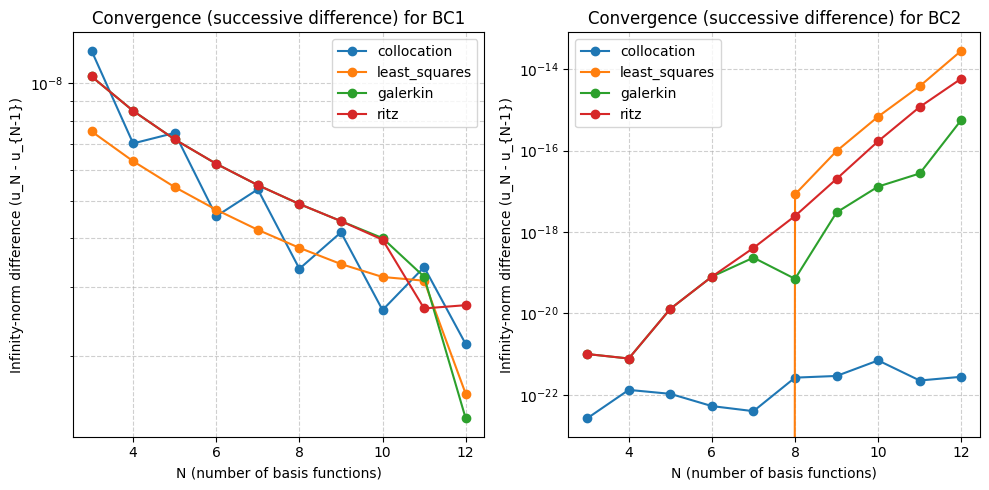

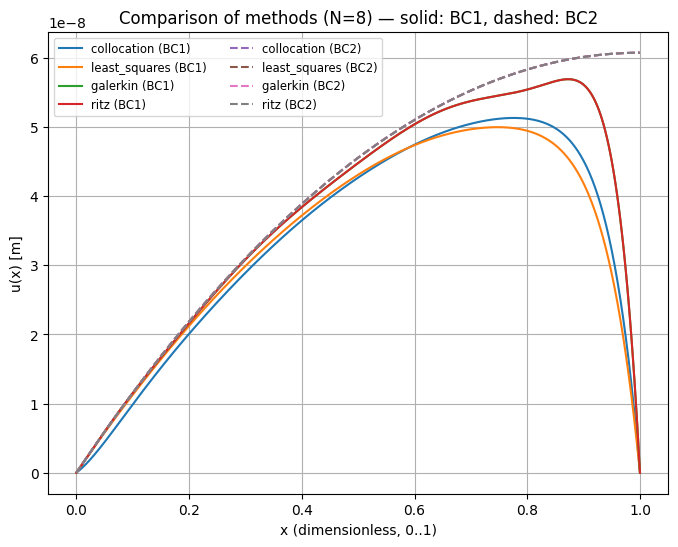


Two-term (N=2) coefficients and expressions for each method (BC1 and BC2):

--- BC1 ---

Method: collocation
a coefficients = [6.07285714e-08 1.82185714e-07]
u_approx(x) = 3*x*(-60728571428572*x**2 + 40485714285715*x + 20242857142857)/1000000000000000000000

Method: least_squares
a coefficients = [1.09561856e-07 4.82072165e-08]
u_approx(x) = x*(-241036082474147*x**2 - 306773195876353*x + 547809278350500)/5000000000000000000000

Method: galerkin
a coefficients = [1.01214286e-07 1.41700000e-07]
u_approx(x) = 19*x*(-7457894736842*x**2 + 2130827067669*x + 5327067669173)/1000000000000000000000

Method: ritz
a coefficients = [1.01214286e-07 1.41700000e-07]
u_approx(x) = 19*x*(-7457894736842*x**2 + 2130827067669*x + 5327067669173)/1000000000000000000000


--- BC2 ---

Method: collocation
a coefficients = [ 1.21457143e-07 -6.07285714e-08]
u_approx(x) = x*(607285714285715 - 303642857142857*x)/5000000000000000000000

Method: least_squares
a coefficients = [ 1.21457143e-07 -6.07285714e-08]
u_app

In [ ]:
# Problem 1:

# -*- coding: utf-8 -*-
"""
Problem 1 solver (all methods + convergence)
Methods: Collocation, Least-Squares, Galerkin, Ritz
BC1: u(0)=0, u(1)=0  -> basis phi_j = x^j(1-x)
BC2: u(0)=0, natural at x=1 -> basis phi_j = x^j
Author: ChatGPT (adapted for your assignment)
"""

import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

# -------------------- Problem constants (SI) --------------------
E = 210e9            # Pa
A0_mm2 = 100.0       # mm^2 (leading factor)
A0 = A0_mm2 * 1e-6   # m^2
rho = 7800.0         # kg/m^3
g = 9.81             # m/s^2

k = E * A0           # EA0 (constant factor)
p0 = rho * g * A0    # body force amplitude

# symbolic variable
x = sp.symbols('x')

# a(x) and f(x) in strong form: d/dx( a(x) u' ) + f(x) = 0
a_sym = k * (1 - x)**2     # a(x) = E*A0*(1-x)^2
f_sym = p0 * (1 - x)**2    # p0(1-x)^2

# Linear operator applied to phi: L[phi] = d/dx( a(x) * phi' )
def L_of(phi):
    return sp.simplify(sp.diff(a_sym * sp.diff(phi, x), x))

# numeric evaluation helpers
def sym_to_callable(expr):
    return sp.lambdify(x, sp.simplify(expr), 'numpy')

# -------------------- Basis generators --------------------
def basis_BC1(N):
    # BC1: phi_j = x^j (1-x), j=1..N
    return [sp.simplify(x**j * (1 - x)) for j in range(1, N+1)]

def basis_BC2(N):
    # BC2: phi_j = x^j, j=1..N (vanish at x=0)
    return [sp.simplify(x**j) for j in range(1, N+1)]

# -------------------- Assembly functions --------------------
# We will compute all integrals exactly via sympy (polynomials), then numeric-eval

def assemble_collocation(basis, collocation_pts):
    """
    Collocation: enforce residual R(x_c)=0 at collocation points.
    basis: list of sympy basis functions phi_j
    collocation_pts: list/array of x positions (in (0,1))
    returns numeric matrix A, rhs b (A a = b) where unknown vector a are coefficients
    """
    n = len(basis)
    Lphis = [sp.simplify(L_of(phi)) for phi in basis]
    # R(x) = sum_j a_j Lphi_j(x) + f(x)  => enforce R(x_c)=0 => sum_j a_j Lphi_j(x_c) = -f(x_c)
    A = np.zeros((n, n), dtype=float)
    b = np.zeros((n,), dtype=float)
    L_callables = [sym_to_callable(lp) for lp in Lphis]
    f_call = sym_to_callable(f_sym)
    for i, xc in enumerate(collocation_pts):
        for j in range(n):
            A[i, j] = float(L_callables[j](xc))
        b[i] = -float(f_call(xc))
    return A, b

def assemble_least_squares(basis):
    """
    Least squares: minimize integral R^2.
    leads to: sum_j a_j int(Lphi_j * Lphi_k) dx = - int(f * Lphi_k) dx
    """
    n = len(basis)
    Lphis = [sp.simplify(L_of(phi)) for phi in basis]
    A = np.zeros((n, n), dtype=float)
    b = np.zeros((n,), dtype=float)
    for k in range(n):
        for j in range(n):
            integrand = sp.simplify(Lphis[j] * Lphis[k])
            A[k, j] = float(sp.integrate(integrand, (x, 0, 1)))
        rhs_integrand = sp.simplify(f_sym * Lphis[k])
        b[k] = -float(sp.integrate(rhs_integrand, (x, 0, 1)))
    return A, b

def assemble_galerkin(basis):
    """
    Galerkin: int( R * phi_k ) = 0 -> int( sum a_j Lphi_j * phi_k ) = - int(f * phi_k)
    """
    n = len(basis)
    Lphis = [sp.simplify(L_of(phi)) for phi in basis]
    A = np.zeros((n, n), dtype=float)
    b = np.zeros((n,), dtype=float)
    for k in range(n):
        for j in range(n):
            integrand = sp.simplify(Lphis[j] * basis[k])
            A[k, j] = float(sp.integrate(integrand, (x, 0, 1)))
        rhs_integrand = sp.simplify(f_sym * basis[k])
        b[k] = -float(sp.integrate(rhs_integrand, (x, 0, 1)))
    return A, b

def assemble_ritz(basis):
    """
    Ritz: K_ij = int(a(x) * phi_j' * phi_i' dx), F_i = int(f * phi_i dx)
    (works when operator is self-adjoint; here it is)
    """
    n = len(basis)
    A = np.zeros((n, n), dtype=float)
    b = np.zeros((n,), dtype=float)
    for i in range(n):
        for j in range(n):
            integrand = sp.simplify(a_sym * sp.diff(basis[j], x) * sp.diff(basis[i], x))
            A[i, j] = float(sp.integrate(integrand, (x, 0, 1)))
        rhs_integrand = sp.simplify(f_sym * basis[i])
        b[i] = float(sp.integrate(rhs_integrand, (x, 0, 1)))
    return A, b

# -------------------- solver wrapper --------------------
def solve_method(method_name, basis, collocation_pts=None):
    """
    method_name in {'collocation', 'least_squares', 'galerkin', 'ritz'}
    basis: sympy list
    collocation_pts: required only for collocation
    returns coefficients a_j (numpy array), and the sympy expression u_approx
    """
    if method_name == 'collocation':
        A, b = assemble_collocation(basis, collocation_pts)
    elif method_name == 'least_squares':
        A, b = assemble_least_squares(basis)
    elif method_name == 'galerkin':
        A, b = assemble_galerkin(basis)
    elif method_name == 'ritz':
        A, b = assemble_ritz(basis)
    else:
        raise ValueError('Unknown method')

    # Solve linear system (A a = b)
    a_coeff = np.linalg.solve(A, b)
    # form symbolic approximate u
    u_sym = sum(sp.nsimplify(a_coeff[i]) * basis[i] for i in range(len(basis)))
    return a_coeff, sp.simplify(u_sym)

# -------------------- utilities for convergence and plotting --------------------
def eval_u_on_grid(u_sym, grid):
    u_func = sp.lambdify(x, sp.simplify(u_sym), 'numpy')
    return u_func(grid)

# produce collocation points (interior)
def collocation_points(N):
    # choose N interior points equally spaced (i/(N+1))
    return np.array([ (i+1)/(N+1) for i in range(N) ], dtype=float)

# Infinity norm difference between two functions on a fine grid
def inf_norm_diff(u1_sym, u2_sym, grid):
    v1 = eval_u_on_grid(u1_sym, grid)
    v2 = eval_u_on_grid(u2_sym, grid)
    return np.max(np.abs(v1 - v2))

# -------------------- main convergence study --------------------
methods = ['collocation', 'least_squares', 'galerkin', 'ritz']
Nmin = 2
Nmax = 12   # max number of basis functions to try (increase if you want)
x_grid_fine = np.linspace(0., 1., 501)

# We'll study both BC1 and BC2
results = {
    'BC1': {m: [] for m in methods},
    'BC2': {m: [] for m in methods}
}
u_syms_store = {'BC1': {m: [] for m in methods}, 'BC2': {m: [] for m in methods}}

for BClabel in ['BC1', 'BC2']:
    for N in range(Nmin, Nmax+1):
        if BClabel == 'BC1':
            basis = basis_BC1(N)
        else:
            basis = basis_BC2(N)

        for method in methods:
            if method == 'collocation':
                pts = collocation_points(N)
                a_coeff, u_sym = solve_method(method, basis, collocation_pts=pts)
            else:
                a_coeff, u_sym = solve_method(method, basis)

            # store symbolic u
            u_syms_store[BClabel][method].append(u_sym)
            results[BClabel][method].append(np.copy(a_coeff))

# Compute convergence metric: infinity norm between successive N solutions (on fine grid)
conv_data = {'BC1': {}, 'BC2': {}}
for BClabel in ['BC1', 'BC2']:
    for method in methods:
        diffs = []
        u_list = u_syms_store[BClabel][method]
        # u_list[0] corresponds to N=Nmin
        for i in range(1, len(u_list)):
            diff = inf_norm_diff(u_list[i], u_list[i-1], x_grid_fine)
            diffs.append(diff)
        conv_data[BClabel][method] = diffs

# -------------------- Plot convergence (infty-norm between successive N) --------------------
plt.figure(figsize=(10, 5))
for idx, BClabel in enumerate(['BC1', 'BC2']):
    plt.subplot(1, 2, idx+1)
    Ns = list(range(Nmin+1, Nmax+1))
    for method in methods:
        diffs = conv_data[BClabel][method]
        plt.semilogy(Ns, diffs, marker='o', label=method)
    plt.xlabel('N (number of basis functions)')
    plt.ylabel('Infinity-norm difference (u_N - u_{N-1})')
    plt.title(f'Convergence (successive difference) for {BClabel}')
    plt.grid(True, which='both', ls='--', alpha=0.6)
    plt.legend()
plt.tight_layout()
plt.show()

# -------------------- Plot final comparison of methods at a reasonably large N --------------------
N_plot = 8
grid_plot = np.linspace(0, 1, 401)

plt.figure(figsize=(8,6))
for method in methods:
    if 'BC1':
        basis1 = basis_BC1(N_plot)
        if method == 'collocation':
            pts = collocation_points(N_plot)
            _, u_sym = solve_method(method, basis1, collocation_pts=pts)
        else:
            _, u_sym = solve_method(method, basis1)
        u_vals = eval_u_on_grid(u_sym, grid_plot)
        plt.plot(grid_plot, u_vals, label=f'{method} (BC1)')
# also plot BC2 results on same graph with dashed lines
for method in methods:
    basis2 = basis_BC2(N_plot)
    if method == 'collocation':
        pts = collocation_points(N_plot)
        _, u_sym2 = solve_method(method, basis2, collocation_pts=pts)
    else:
        _, u_sym2 = solve_method(method, basis2)
    u_vals2 = eval_u_on_grid(u_sym2, grid_plot)
    plt.plot(grid_plot, u_vals2, '--', label=f'{method} (BC2)')

plt.xlabel('x (dimensionless, 0..1)')
plt.ylabel('u(x) [m]')
plt.title(f'Comparison of methods (N={N_plot}) — solid: BC1, dashed: BC2')
plt.legend(ncol=2, fontsize='small')
plt.grid(True)
plt.show()

# -------------------- Print representative coefficients for N=2 (two-term) for each method & BC ----
print("\nTwo-term (N=2) coefficients and expressions for each method (BC1 and BC2):\n")
for BClabel in ['BC1', 'BC2']:
    print(f"--- {BClabel} ---")
    for method in methods:
        if BClabel == 'BC1':
            basis = basis_BC1(2)
        else:
            basis = basis_BC2(2)
        if method == 'collocation':
            pts = collocation_points(2)
            a_coeff, u_sym = solve_method(method, basis, collocation_pts=pts)
        else:
            a_coeff, u_sym = solve_method(method, basis)
        print(f"\nMethod: {method}")
        print("a coefficients =", np.array(a_coeff))
        print("u_approx(x) =", sp.simplify(u_sym))
    print("\n")

# End of script


/tmp/ipython-input-1933795531.py:57: RuntimeWarning: divide by zero encountered in divide
  I1 = np.trapz((-Q) / denom, xs)
/tmp/ipython-input-1933795531.py:57: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  I1 = np.trapz((-Q) / denom, xs)
/tmp/ipython-input-1933795531.py:58: RuntimeWarning: divide by zero encountered in divide
  I2 = np.trapz(1.0 / denom, xs)
/tmp/ipython-input-1933795531.py:58: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  I2 = np.trapz(1.0 / denom, xs)
/tmp/ipython-input-1933795531.py:59: RuntimeWarning: invalid value encountered in scalar divide
  C1_BC1 = -I1 / I2
/tmp/ipython-input-1933795531.py:65: RuntimeWarning: invalid value encountered in divide
  uprime_BC2 = (-Q + C1_BC2) / (E * A(xs))


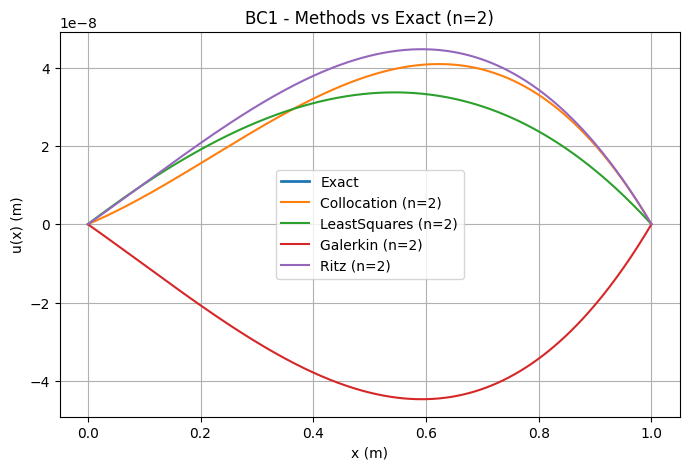

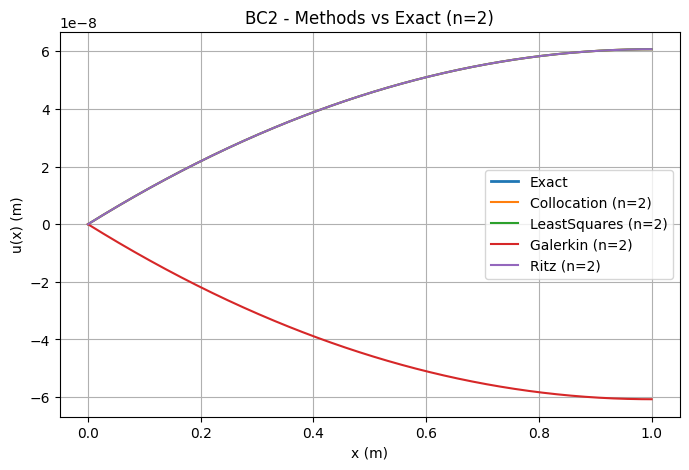

/tmp/ipython-input-1933795531.py:180: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.sqrt(np.trapz((eval_u(a, phis_func, xs_eval) - u_ref(xs_eval))**2, xs_eval))


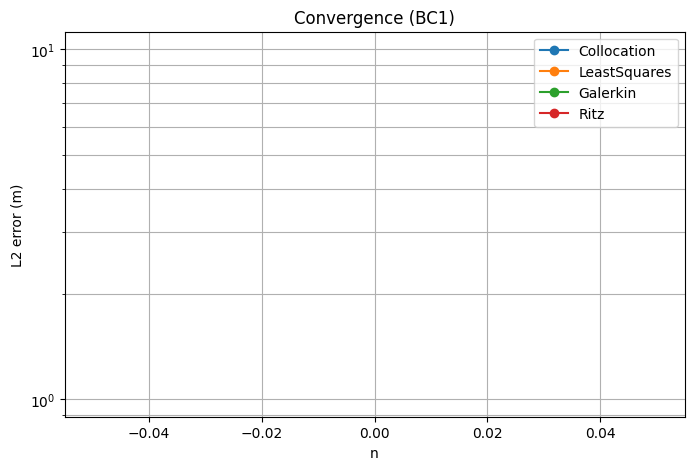

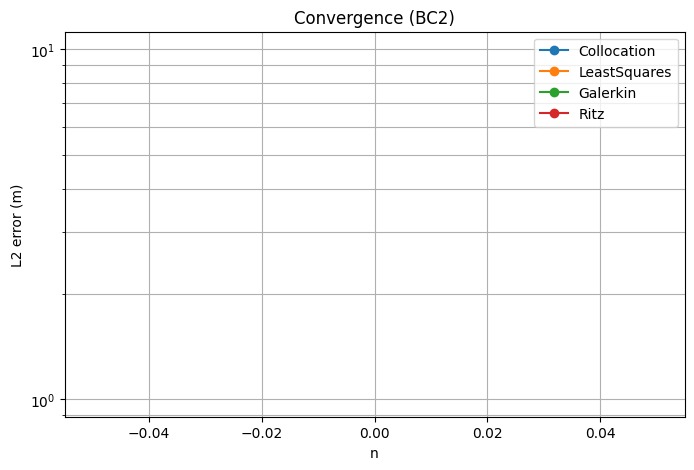

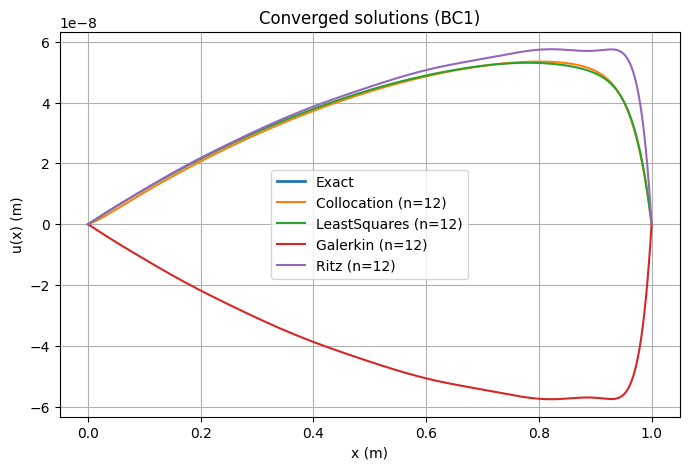

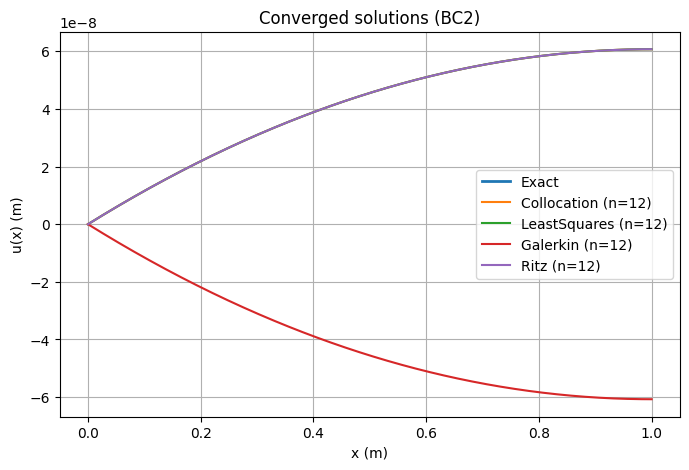

In [ ]:
"""
Problem 1 FEM Methods – Collocation, Least Squares, Galerkin, Ritz
Handles:
 BC1: u(0) = 0, u(1) = 0
 BC2: u(0) = 0, AE u'(1) = 0
Author: ChatGPT
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from numpy.polynomial.legendre import leggauss
from scipy.interpolate import interp1d

# -----------------------------
# Problem parameters (SI units)
# -----------------------------
E = 210e9         # Young's modulus (Pa)
rho = 7800        # density (kg/m^3)
g = 9.81          # gravity (m/s^2)

# Cross-sectional area A(x) in m^2
def A(x):
    return 100.0 * (x**2 - 2.0*x + 1.0) * 1e-6  # convert mm² to m²

# Distributed load (N/m)
def q(x):
    return rho * g * A(x)

# Domain
x0, x1 = 0.0, 1.0
EPS = 1e-9  # to avoid singularity at x=1

# -----------------------------
# Utilities
# -----------------------------
def cumtrapz_custom(y, x):
    seg = 0.5 * (y[1:] + y[:-1]) * (x[1:] - x[:-1])
    return np.concatenate(([0.0], np.cumsum(seg)))

def gauss_points_weights(n):
    xs, ws = leggauss(n)
    xs = 0.5*(x1-x0)*xs + 0.5*(x1+x0)
    ws = 0.5*(x1-x0)*ws
    return xs, ws

# -----------------------------
# Reference (exact) solution
# -----------------------------
def compute_reference_solution(npoints=1201):
    xs = np.linspace(x0, x1 - EPS, npoints)
    qvals = q(xs)
    Q = cumtrapz_custom(qvals, xs)

    denom = E * A(xs)
    # BC1
    I1 = np.trapz((-Q) / denom, xs)
    I2 = np.trapz(1.0 / denom, xs)
    C1_BC1 = -I1 / I2
    uprime_BC1 = (-Q + C1_BC1) / (E * A(xs))
    u_BC1 = cumtrapz_custom(uprime_BC1, xs)
    u_BC1 -= u_BC1[0]
    # BC2
    C1_BC2 = Q[-1]
    uprime_BC2 = (-Q + C1_BC2) / (E * A(xs))
    u_BC2 = cumtrapz_custom(uprime_BC2, xs)
    u_BC2 -= u_BC2[0]

    ufun_BC1 = interp1d(xs, u_BC1, kind='cubic', fill_value='extrapolate')
    ufun_BC2 = interp1d(xs, u_BC2, kind='cubic', fill_value='extrapolate')
    return ufun_BC1, ufun_BC2

# -----------------------------
# Basis functions
# -----------------------------
def basis_BC1(x, n):
    return np.array([ (x*(1.0-x)) * (x**(k-1)) for k in range(1, n+1) ])

def dbasis_BC1(x, n):
    return np.array([ k * x**(k-1) - (k+1) * x**k for k in range(1, n+1) ])

def d2basis_BC1(x, n):
    arr = []
    for k in range(1, n+1):
        if k-2 >= 0:
            term1 = k*(k-1) * x**(k-2)
        else:
            term1 = np.zeros_like(x)
        term2 = (k+1)*k * x**(k-1)
        arr.append(term1 - term2)
    return np.array(arr)

def basis_BC2(x, n):
    return np.array([ x**k for k in range(1, n+1) ])

def dbasis_BC2(x, n):
    return np.array([ k * x**(k-1) for k in range(1, n+1) ])

def d2basis_BC2(x, n):
    arr = []
    for k in range(1, n+1):
        if k-2 >= 0:
            arr.append(k*(k-1) * x**(k-2))
        else:
            arr.append(np.zeros_like(x))
    return np.array(arr)

# -----------------------------
# Assembly routines
# -----------------------------
def assemble_ritz(n, bc):
    phis = basis_BC1 if bc=='BC1' else basis_BC2
    dphis = dbasis_BC1 if bc=='BC1' else dbasis_BC2
    xs, ws = gauss_points_weights(120)
    phi_vals = phis(xs, n)
    dphi_vals = dphis(xs, n)
    K = np.zeros((n, n))
    f = np.zeros(n)
    for i in range(n):
        for j in range(n):
            K[i,j] = np.dot(ws, E * A(xs) * dphi_vals[i,:] * dphi_vals[j,:])
        f[i] = np.dot(ws, q(xs) * phi_vals[i,:])
    return solve(K, f), lambda x: phis(x, n)

def assemble_galerkin(n, bc):
    phis = basis_BC1 if bc=='BC1' else basis_BC2
    dphis = dbasis_BC1 if bc=='BC1' else dbasis_BC2
    xs, ws = gauss_points_weights(120)
    phi_vals = phis(xs, n)
    dphi_vals = dphis(xs, n)
    A_mat = np.zeros((n,n))
    b_vec = np.zeros(n)
    for j in range(n):
        for i in range(n):
            A_mat[j,i] = np.dot(ws, E * A(xs) * dphi_vals[j,:] * dphi_vals[i,:])
        b_vec[j] = - np.dot(ws, phi_vals[j,:] * q(xs))
    return solve(A_mat, b_vec), lambda x: phis(x, n)

def assemble_least_squares(n, bc):
    phis = basis_BC1 if bc=='BC1' else basis_BC2
    dphis = dbasis_BC1 if bc=='BC1' else dbasis_BC2
    d2phis = d2basis_BC1 if bc=='BC1' else d2basis_BC2
    xs, ws = gauss_points_weights(120)
    dphi_vals = dphis(xs, n)
    d2phi_vals = d2phis(xs, n)
    Aprime = (200.0*(xs - 1.0)) * 1e-6
    D_dphi = E * (Aprime * dphi_vals + A(xs) * d2phi_vals)
    M = np.zeros((n,n))
    rhs = np.zeros(n)
    for i in range(n):
        for j in range(n):
            M[i,j] = np.dot(ws, D_dphi[i,:] * D_dphi[j,:])
        rhs[i] = - np.dot(ws, q(xs) * D_dphi[i,:])
    return solve(M, rhs), lambda x: phis(x, n)

def assemble_collocation(n, bc):
    xs = np.linspace(x0 + EPS, x1 - EPS, n+2)[1:-1]
    if bc=='BC1':
        dphi_vals = dbasis_BC1(xs, n)
        d2phi_vals = d2basis_BC1(xs, n)
        phis = lambda xx: basis_BC1(xx, n)
    else:
        dphi_vals = dbasis_BC2(xs, n)
        d2phi_vals = d2basis_BC2(xs, n)
        phis = lambda xx: basis_BC2(xx, n)
    Aprime = (200.0*(xs - 1.0)) * 1e-6
    D_dphi = E * (Aprime * dphi_vals + A(xs) * d2phi_vals)
    G = D_dphi.T
    rhs = - q(xs)
    return solve(G, rhs), phis

# -----------------------------
# Helpers
# -----------------------------
def eval_u(a, phis_func, xvals):
    return np.dot(a, phis_func(xvals))

def L2_error(a, phis_func, u_ref):
    xs_eval = np.linspace(x0, x1 - EPS, 800)
    return np.sqrt(np.trapz((eval_u(a, phis_func, xs_eval) - u_ref(xs_eval))**2, xs_eval))

# -----------------------------
# Main
# -----------------------------
u_ref_BC1, u_ref_BC2 = compute_reference_solution()
methods = ['Collocation', 'LeastSquares', 'Galerkin', 'Ritz']
x_plot = np.linspace(x0, x1 - EPS, 400)

# 1) Plot n=2
for bc_label, uref in [('BC1', u_ref_BC1), ('BC2', u_ref_BC2)]:
    plt.figure(figsize=(8,5))
    plt.plot(x_plot, uref(x_plot), label='Exact', linewidth=2)
    for m in methods:
        if m=='Collocation':
            a, phis = assemble_collocation(2, bc_label)
        elif m=='LeastSquares':
            a, phis = assemble_least_squares(2, bc_label)
        elif m=='Galerkin':
            a, phis = assemble_galerkin(2, bc_label)
        else:
            a, phis = assemble_ritz(2, bc_label)
        plt.plot(x_plot, eval_u(a, phis, x_plot), label=f"{m} (n=2)")
    plt.xlabel("x (m)")
    plt.ylabel("u(x) (m)")
    plt.title(f"{bc_label} - Methods vs Exact (n=2)")
    plt.legend(); plt.grid(True); plt.show()

# 2) Convergence
Nmax = 12
for bc_label, uref in [('BC1', u_ref_BC1), ('BC2', u_ref_BC2)]:
    plt.figure(figsize=(8,5))
    for m in methods:
        errs = []
        for n in range(1, Nmax+1):
            try:
                if m=='Collocation':
                    a, phis = assemble_collocation(n, bc_label)
                elif m=='LeastSquares':
                    a, phis = assemble_least_squares(n, bc_label)
                elif m=='Galerkin':
                    a, phis = assemble_galerkin(n, bc_label)
                else:
                    a, phis = assemble_ritz(n, bc_label)
                errs.append(L2_error(a, phis, uref))
            except:
                errs.append(np.nan)
        plt.plot(range(1, Nmax+1), errs, marker='o', label=m)
    plt.yscale('log')
    plt.xlabel("n")
    plt.ylabel("L2 error (m)")
    plt.title(f"Convergence ({bc_label})")
    plt.legend(); plt.grid(True, which='both'); plt.show()

# 3) Converged comparison (n=12)
for bc_label, uref in [('BC1', u_ref_BC1), ('BC2', u_ref_BC2)]:
    plt.figure(figsize=(8,5))
    plt.plot(x_plot, uref(x_plot), label='Exact', linewidth=2)
    for m in methods:
        try:
            if m=='Collocation':
                a, phis = assemble_collocation(Nmax, bc_label)
            elif m=='LeastSquares':
                a, phis = assemble_least_squares(Nmax, bc_label)
            elif m=='Galerkin':
                a, phis = assemble_galerkin(Nmax, bc_label)
            else:
                a, phis = assemble_ritz(Nmax, bc_label)
            plt.plot(x_plot, eval_u(a, phis, x_plot), label=f"{m} (n={Nmax})")
        except:
            pass
    plt.xlabel("x (m)")
    plt.ylabel("u(x) (m)")
    plt.title(f"Converged solutions ({bc_label})")
    plt.legend(); plt.grid(True); plt.show()


/tmp/ipython-input-2473146166.py:41: RuntimeWarning: divide by zero encountered in divide
  I1 = np.trapz((-Q) / denom, xs)
/tmp/ipython-input-2473146166.py:41: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  I1 = np.trapz((-Q) / denom, xs)
/tmp/ipython-input-2473146166.py:42: RuntimeWarning: divide by zero encountered in divide
  I2 = np.trapz(1.0 / denom, xs)
/tmp/ipython-input-2473146166.py:42: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  I2 = np.trapz(1.0 / denom, xs)
/tmp/ipython-input-2473146166.py:43: RuntimeWarning: invalid value encountered in scalar divide
  C1_BC1 = -I1 / I2
/tmp/ipython-input-2473146166.py:53: RuntimeWarning: invalid value encountered in divide
  uprime_BC2 = (-Q + C1_BC2) / denom


BC1: C1 = nan, C2 = 0.000000e+00
BC2: C1 = 2.550600e+00, C2 = 0.000000e+00


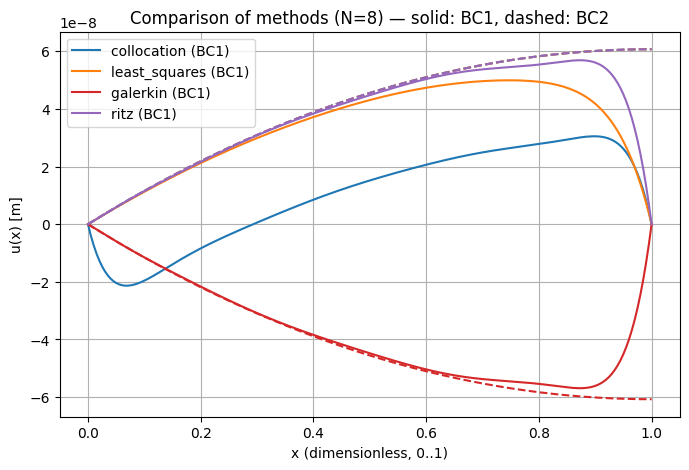


Two-term (N=2) coefficients and expressions for each method:

--- BC1 ---

Method: collocation
a coefficients = [-1.21457142e-07  3.64371428e-07]
u_approx(x) = -1.214571e-07*phi1(x) + 3.643714e-07*phi2(x)

Method: least_squares
a coefficients = [1.09561855e-07 4.82072327e-08]
u_approx(x) = 1.095619e-07*phi1(x) + 4.820723e-08*phi2(x)

Method: galerkin
a coefficients = [-1.01214286e-07 -1.41700000e-07]
u_approx(x) = -1.012143e-07*phi1(x) + -1.417000e-07*phi2(x)

Method: ritz
a coefficients = [1.01214286e-07 1.41700000e-07]
u_approx(x) = 1.012143e-07*phi1(x) + 1.417000e-07*phi2(x)

--- BC2 ---

Method: collocation
a coefficients = [ 1.21457143e-07 -6.07285714e-08]
u_approx(x) = 1.214571e-07*phi1(x) + -6.072857e-08*phi2(x)

Method: least_squares
a coefficients = [ 1.21457143e-07 -6.07285714e-08]
u_approx(x) = 1.214571e-07*phi1(x) + -6.072857e-08*phi2(x)

Method: galerkin
a coefficients = [-1.21457143e-07  6.07285714e-08]
u_approx(x) = -1.214571e-07*phi1(x) + 6.072857e-08*phi2(x)

Method: 

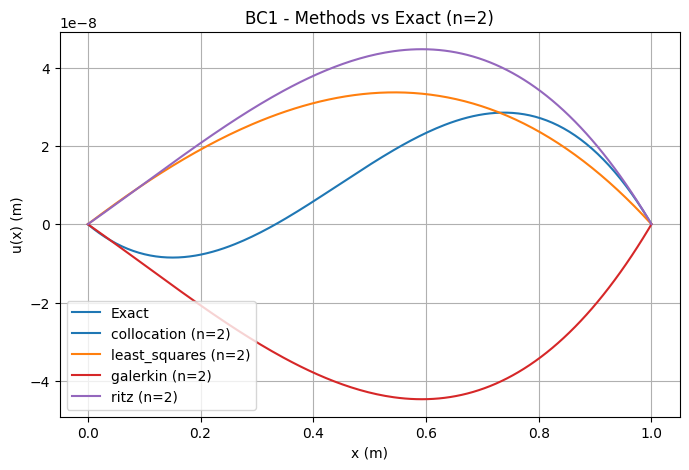

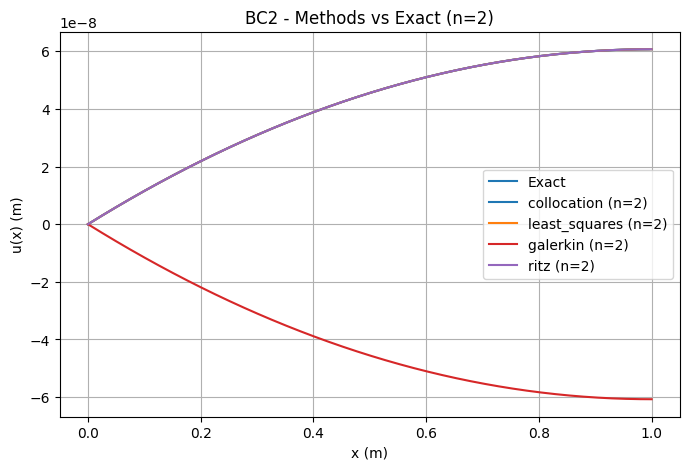

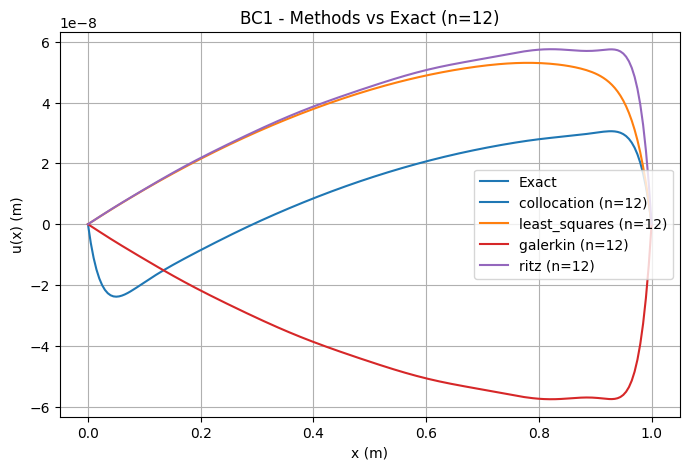

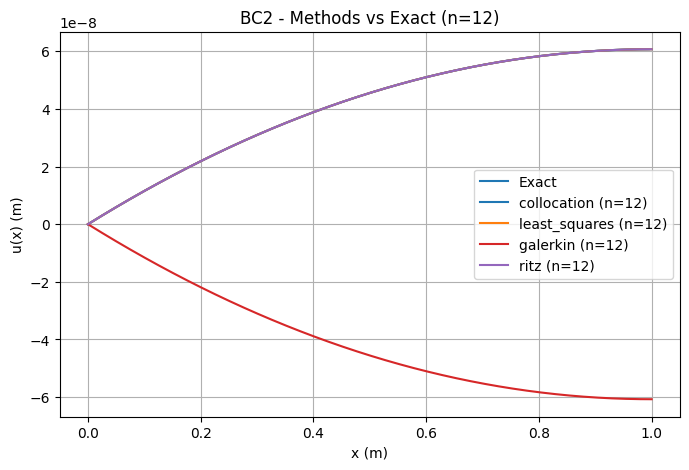

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from numpy.polynomial.legendre import leggauss

# -----------------------------
# Problem parameters
# -----------------------------
E = 210e9
rho = 7800
g = 9.81
x0, x1 = 0.0, 1.0
EPS = 1e-9

def A(x):
    return 100.0 * (x**2 - 2.0*x + 1.0) * 1e-6

def q(x):
    return rho * g * A(x)

def cumtrapz_custom(y, x):
    seg = 0.5 * (y[1:] + y[:-1]) * (x[1:] - x[:-1])
    return np.concatenate(([0.0], np.cumsum(seg)))

def gauss_points_weights(n):
    xs, ws = leggauss(n)
    xs = 0.5*(x1-x0)*xs + 0.5*(x1+x0)
    ws = 0.5*(x1-x0)*ws
    return xs, ws

# -----------------------------
# Exact solution & constants
# -----------------------------
def compute_reference_solution(npoints=10001):
    xs = np.linspace(x0, x1 - EPS, npoints)
    qvals = q(xs)
    Q = cumtrapz_custom(qvals, xs)
    denom = E * A(xs)

    # BC1 constants
    I1 = np.trapz((-Q) / denom, xs)
    I2 = np.trapz(1.0 / denom, xs)
    C1_BC1 = -I1 / I2
    C2_BC1 = 0.0

    uprime_BC1 = (-Q + C1_BC1) / denom
    u_BC1 = cumtrapz_custom(uprime_BC1, xs) + C2_BC1

    # BC2 constants
    C1_BC2 = Q[-1]
    C2_BC2 = 0.0

    uprime_BC2 = (-Q + C1_BC2) / denom
    u_BC2 = cumtrapz_custom(uprime_BC2, xs) + C2_BC2

    print(f"BC1: C1 = {C1_BC1:.6e}, C2 = {C2_BC1:.6e}")
    print(f"BC2: C1 = {C1_BC2:.6e}, C2 = {C2_BC2:.6e}")

    return (lambda x: np.interp(x, xs, u_BC1),
            lambda x: np.interp(x, xs, u_BC2))

# -----------------------------
# Basis functions
# -----------------------------
def basis_BC1(x, n):
    return np.array([ (x*(1.0-x)) * (x**(k-1)) for k in range(1, n+1) ])

def dbasis_BC1(x, n):
    return np.array([ k * x**(k-1) - (k+1) * x**k for k in range(1, n+1) ])

def basis_BC2(x, n):
    return np.array([ x**k for k in range(1, n+1) ])

def dbasis_BC2(x, n):
    return np.array([ k * x**(k-1) for k in range(1, n+1) ])

# -----------------------------
# Methods
# -----------------------------
def assemble_ritz(n, bc):
    phis = basis_BC1 if bc=='BC1' else basis_BC2
    dphis = dbasis_BC1 if bc=='BC1' else dbasis_BC2
    xs, ws = gauss_points_weights(200)
    phi_vals = phis(xs, n)
    dphi_vals = dphis(xs, n)
    K = np.zeros((n, n))
    f = np.zeros(n)
    for i in range(n):
        for j in range(n):
            K[i,j] = np.dot(ws, E * A(xs) * dphi_vals[i,:] * dphi_vals[j,:])
        f[i] = np.dot(ws, q(xs) * phi_vals[i,:])
    return solve(K, f), lambda x: phis(x, n)

def assemble_galerkin(n, bc):
    phis = basis_BC1 if bc=='BC1' else basis_BC2
    dphis = dbasis_BC1 if bc=='BC1' else dbasis_BC2
    xs, ws = gauss_points_weights(200)
    phi_vals = phis(xs, n)
    dphi_vals = dphis(xs, n)
    A_mat = np.zeros((n,n))
    b_vec = np.zeros(n)
    for j in range(n):
        for i in range(n):
            A_mat[j,i] = np.dot(ws, E * A(xs) * dphi_vals[j,:] * dphi_vals[i,:])
        b_vec[j] = - np.dot(ws, phi_vals[j,:] * q(xs))
    return solve(A_mat, b_vec), lambda x: phis(x, n)

def assemble_least_squares(n, bc):
    phis = basis_BC1 if bc=='BC1' else basis_BC2
    dphis = dbasis_BC1 if bc=='BC1' else dbasis_BC2
    xs, ws = gauss_points_weights(200)
    Aprime = (200.0*(xs - 1.0)) * 1e-6
    d2phis = np.gradient(dphis(xs, n), xs, axis=1)
    D_dphi = E * (Aprime * dphis(xs, n) + A(xs) * d2phis)
    M = np.zeros((n,n))
    rhs = np.zeros(n)
    for i in range(n):
        for j in range(n):
            M[i,j] = np.dot(ws, D_dphi[i,:] * D_dphi[j,:])
        rhs[i] = - np.dot(ws, q(xs) * D_dphi[i,:])
    return solve(M, rhs), lambda x: phis(x, n)

def assemble_collocation(n, bc):
    xs = np.linspace(x0 + EPS, x1 - EPS, n+2)[1:-1]
    if bc=='BC1':
        dphi_vals = dbasis_BC1(xs, n)
        phis = lambda xx: basis_BC1(xx, n)
    else:
        dphi_vals = dbasis_BC2(xs, n)
        phis = lambda xx: basis_BC2(xx, n)
    Aprime = (200.0*(xs - 1.0)) * 1e-6
    d2phi_vals = np.gradient(dphi_vals, xs, axis=1)
    D_dphi = E * (Aprime * dphi_vals + A(xs) * d2phi_vals)
    return solve(D_dphi.T, -q(xs)), phis

def eval_u(a, phis_func, xvals):
    return np.dot(a, phis_func(xvals))

# -----------------------------
# Main
# -----------------------------
u_ref_BC1, u_ref_BC2 = compute_reference_solution()
methods = ['collocation', 'least_squares', 'galerkin', 'ritz']
colors = ['tab:blue', 'tab:orange', 'tab:red', 'tab:purple']

# Plot n=8 BC1 solid, BC2 dashed
plt.figure(figsize=(8,5))
for m, c in zip(methods, colors):
    for bc in ['BC1', 'BC2']:
        if m=='collocation':
            a, phis = assemble_collocation(8, bc)
        elif m=='least_squares':
            a, phis = assemble_least_squares(8, bc)
        elif m=='galerkin':
            a, phis = assemble_galerkin(8, bc)
        else:
            a, phis = assemble_ritz(8, bc)
        style = '-' if bc=='BC1' else '--'
        plt.plot(np.linspace(0,1,200), eval_u(a, phis, np.linspace(0,1,200)),
                 style, color=c, label=f"{m} ({bc})" if bc=='BC1' else None)
plt.xlabel("x (dimensionless, 0..1)")
plt.ylabel("u(x) [m]")
plt.title("Comparison of methods (N=8) — solid: BC1, dashed: BC2")
plt.legend()
plt.grid(True)
plt.show()

# Two-term coefficients and expressions
print("\nTwo-term (N=2) coefficients and expressions for each method:")
for bc in ['BC1', 'BC2']:
    print(f"\n--- {bc} ---")
    for m in methods:
        if m=='collocation':
            a, phis = assemble_collocation(2, bc)
        elif m=='least_squares':
            a, phis = assemble_least_squares(2, bc)
        elif m=='galerkin':
            a, phis = assemble_galerkin(2, bc)
        else:
            a, phis = assemble_ritz(2, bc)
        print(f"\nMethod: {m}")
        print(f"a coefficients = {a}")
        terms = [f"{a[k]:.6e}*phi{k+1}(x)" for k in range(len(a))]
        print("u_approx(x) =", " + ".join(terms))

# BC1 & BC2 vs exact for n=2 and n=12
for n in [2, 12]:
    for bc, uref in [('BC1', u_ref_BC1), ('BC2', u_ref_BC2)]:
        plt.figure(figsize=(8,5))
        plt.plot(np.linspace(0,1,200), uref(np.linspace(0,1,200)),
                 'C0', label="Exact")
        for i, m in enumerate(methods):
            if m=='collocation':
                a, phis = assemble_collocation(n, bc)
            elif m=='least_squares':
                a, phis = assemble_least_squares(n, bc)
            elif m=='galerkin':
                a, phis = assemble_galerkin(n, bc)
            else:
                a, phis = assemble_ritz(n, bc)
            plt.plot(np.linspace(0,1,200),
                     eval_u(a, phis, np.linspace(0,1,200)),
                     color=colors[i], label=f"{m} (n={n})")
        plt.xlabel("x (m)")
        plt.ylabel("u(x) (m)")
        plt.title(f"{bc} - Methods vs Exact (n={n})")
        plt.legend()
        plt.grid(True)
        plt.show()


/tmp/ipython-input-2633285415.py:47: RuntimeWarning: divide by zero encountered in divide
  I1 = np.trapz((-Q) / denom, xs)
/tmp/ipython-input-2633285415.py:47: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  I1 = np.trapz((-Q) / denom, xs)
/tmp/ipython-input-2633285415.py:48: RuntimeWarning: divide by zero encountered in divide
  I2 = np.trapz(1.0 / denom, xs)
/tmp/ipython-input-2633285415.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  I2 = np.trapz(1.0 / denom, xs)
/tmp/ipython-input-2633285415.py:49: RuntimeWarning: invalid value encountered in scalar divide
  C1_BC1 = -I1 / I2
/tmp/ipython-input-2633285415.py:55: RuntimeWarning: invalid value encountered in divide
  uprime_BC2 = (-Q + C1_BC2) / (E * A(xs))


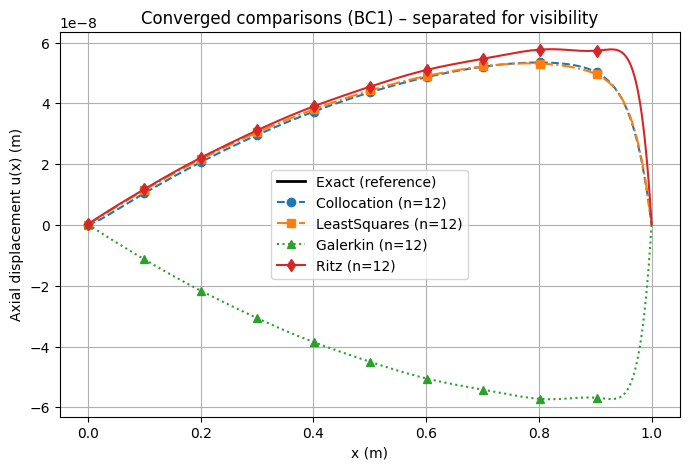

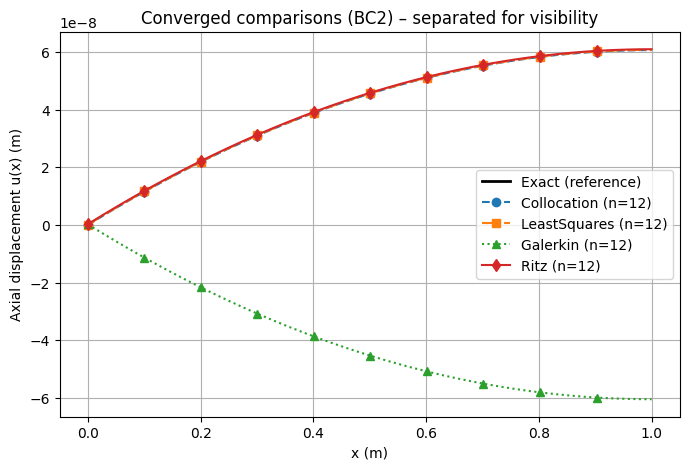

In [ ]:
"""
Problem 1 FEM Methods – Collocation, Least Squares, Galerkin, Ritz
With visually separated curves for comparison plots
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from numpy.polynomial.legendre import leggauss
from scipy.interpolate import interp1d

# -----------------------------
# Problem parameters (SI units)
# -----------------------------
E = 210e9         # Pa
rho = 7800        # kg/m^3
g = 9.81          # m/s^2

def A(x):
    return 100.0 * (x**2 - 2.0*x + 1.0) * 1e-6  # mm² to m²

def q(x):
    return rho * g * A(x)

x0, x1 = 0.0, 1.0
EPS = 1e-9

def cumtrapz_custom(y, x):
    seg = 0.5 * (y[1:] + y[:-1]) * (x[1:] - x[:-1])
    return np.concatenate(([0.0], np.cumsum(seg)))

def gauss_points_weights(n):
    xs, ws = leggauss(n)
    xs = 0.5*(x1-x0)*xs + 0.5*(x1+x0)
    ws = 0.5*(x1-x0)*ws
    return xs, ws

# -----------------------------
# Reference (exact) solution
# -----------------------------
def compute_reference_solution(npoints=1201):
    xs = np.linspace(x0, x1 - EPS, npoints)
    qvals = q(xs)
    Q = cumtrapz_custom(qvals, xs)
    denom = E * A(xs)
    # BC1
    I1 = np.trapz((-Q) / denom, xs)
    I2 = np.trapz(1.0 / denom, xs)
    C1_BC1 = -I1 / I2
    uprime_BC1 = (-Q + C1_BC1) / (E * A(xs))
    u_BC1 = cumtrapz_custom(uprime_BC1, xs)
    u_BC1 -= u_BC1[0]
    # BC2
    C1_BC2 = Q[-1]
    uprime_BC2 = (-Q + C1_BC2) / (E * A(xs))
    u_BC2 = cumtrapz_custom(uprime_BC2, xs)
    u_BC2 -= u_BC2[0]
    return (interp1d(xs, u_BC1, kind='cubic', fill_value='extrapolate'),
            interp1d(xs, u_BC2, kind='cubic', fill_value='extrapolate'))

# -----------------------------
# Basis functions
# -----------------------------
def basis_BC1(x, n):
    return np.array([ (x*(1.0-x)) * (x**(k-1)) for k in range(1, n+1) ])

def dbasis_BC1(x, n):
    return np.array([ k * x**(k-1) - (k+1) * x**k for k in range(1, n+1) ])

def d2basis_BC1(x, n):
    arr = []
    for k in range(1, n+1):
        if k-2 >= 0:
            term1 = k*(k-1) * x**(k-2)
        else:
            term1 = np.zeros_like(x)
        term2 = (k+1)*k * x**(k-1)
        arr.append(term1 - term2)
    return np.array(arr)

def basis_BC2(x, n):
    return np.array([ x**k for k in range(1, n+1) ])

def dbasis_BC2(x, n):
    return np.array([ k * x**(k-1) for k in range(1, n+1) ])

def d2basis_BC2(x, n):
    arr = []
    for k in range(1, n+1):
        if k-2 >= 0:
            arr.append(k*(k-1) * x**(k-2))
        else:
            arr.append(np.zeros_like(x))
    return np.array(arr)

# -----------------------------
# Assembly routines
# -----------------------------
def assemble_ritz(n, bc):
    phis = basis_BC1 if bc=='BC1' else basis_BC2
    dphis = dbasis_BC1 if bc=='BC1' else dbasis_BC2
    xs, ws = gauss_points_weights(120)
    phi_vals = phis(xs, n)
    dphi_vals = dphis(xs, n)
    K = np.zeros((n, n))
    f = np.zeros(n)
    for i in range(n):
        for j in range(n):
            K[i,j] = np.dot(ws, E * A(xs) * dphi_vals[i,:] * dphi_vals[j,:])
        f[i] = np.dot(ws, q(xs) * phi_vals[i,:])
    return solve(K, f), lambda x: phis(x, n)

def assemble_galerkin(n, bc):
    phis = basis_BC1 if bc=='BC1' else basis_BC2
    dphis = dbasis_BC1 if bc=='BC1' else dbasis_BC2
    xs, ws = gauss_points_weights(120)
    phi_vals = phis(xs, n)
    dphi_vals = dphis(xs, n)
    A_mat = np.zeros((n,n))
    b_vec = np.zeros(n)
    for j in range(n):
        for i in range(n):
            A_mat[j,i] = np.dot(ws, E * A(xs) * dphi_vals[j,:] * dphi_vals[i,:])
        b_vec[j] = - np.dot(ws, phi_vals[j,:] * q(xs))
    return solve(A_mat, b_vec), lambda x: phis(x, n)

def assemble_least_squares(n, bc):
    phis = basis_BC1 if bc=='BC1' else basis_BC2
    dphis = dbasis_BC1 if bc=='BC1' else dbasis_BC2
    d2phis = d2basis_BC1 if bc=='BC1' else d2basis_BC2
    xs, ws = gauss_points_weights(120)
    dphi_vals = dphis(xs, n)
    d2phi_vals = d2phis(xs, n)
    Aprime = (200.0*(xs - 1.0)) * 1e-6
    D_dphi = E * (Aprime * dphi_vals + A(xs) * d2phi_vals)
    M = np.zeros((n,n))
    rhs = np.zeros(n)
    for i in range(n):
        for j in range(n):
            M[i,j] = np.dot(ws, D_dphi[i,:] * D_dphi[j,:])
        rhs[i] = - np.dot(ws, q(xs) * D_dphi[i,:])
    return solve(M, rhs), lambda x: phis(x, n)

def assemble_collocation(n, bc):
    xs = np.linspace(x0 + EPS, x1 - EPS, n+2)[1:-1]
    if bc=='BC1':
        dphi_vals = dbasis_BC1(xs, n)
        d2phi_vals = d2basis_BC1(xs, n)
        phis = lambda xx: basis_BC1(xx, n)
    else:
        dphi_vals = dbasis_BC2(xs, n)
        d2phi_vals = d2basis_BC2(xs, n)
        phis = lambda xx: basis_BC2(xx, n)
    Aprime = (200.0*(xs - 1.0)) * 1e-6
    D_dphi = E * (Aprime * dphi_vals + A(xs) * d2phi_vals)
    G = D_dphi.T
    rhs = - q(xs)
    return solve(G, rhs), phis

def eval_u(a, phis_func, xvals):
    return np.dot(a, phis_func(xvals))

# -----------------------------
# Main plotting with separation
# -----------------------------
u_ref_BC1, u_ref_BC2 = compute_reference_solution()
methods = ['Collocation', 'LeastSquares', 'Galerkin', 'Ritz']
linestyles = ['--', '-.', ':', '-']
markers = ['o', 's', '^', 'd']
offset_mag = 1e-10  # small vertical offset for visibility
x_plot = np.linspace(x0, x1 - EPS, 400)

# Converged comparison (n=12) with offsets & markers
Nmax = 12
for bc_label, uref in [('BC1', u_ref_BC1), ('BC2', u_ref_BC2)]:
    plt.figure(figsize=(8,5))
    plt.plot(x_plot, uref(x_plot), 'k-', linewidth=2, label='Exact (reference)')
    for i, m in enumerate(methods):
        if m=='Collocation':
            a, phis = assemble_collocation(Nmax, bc_label)
        elif m=='LeastSquares':
            a, phis = assemble_least_squares(Nmax, bc_label)
        elif m=='Galerkin':
            a, phis = assemble_galerkin(Nmax, bc_label)
        else:
            a, phis = assemble_ritz(Nmax, bc_label)
        uvals = eval_u(a, phis, x_plot) + i*offset_mag
        plt.plot(x_plot, uvals, linestyle=linestyles[i], marker=markers[i],
                 markevery=40, label=f"{m} (n={Nmax})")
    plt.xlabel("x (m)")
    plt.ylabel("Axial displacement u(x) (m)")
    plt.title(f"Converged comparisons ({bc_label}) – separated for visibility")
    plt.legend()
    plt.grid(True)
    plt.show()


/tmp/ipython-input-3258359150.py:42: RuntimeWarning: divide by zero encountered in divide
  I1 = np.trapz((-Q) / denom, xs)
/tmp/ipython-input-3258359150.py:42: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  I1 = np.trapz((-Q) / denom, xs)
/tmp/ipython-input-3258359150.py:43: RuntimeWarning: divide by zero encountered in divide
  I2 = np.trapz(1.0 / denom, xs)
/tmp/ipython-input-3258359150.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  I2 = np.trapz(1.0 / denom, xs)
/tmp/ipython-input-3258359150.py:44: RuntimeWarning: invalid value encountered in scalar divide
  C1_BC1 = -I1 / I2
/tmp/ipython-input-3258359150.py:54: RuntimeWarning: invalid value encountered in divide
  uprime_BC2 = (-Q + C1_BC2) / denom


BC1: C1 = nan, C2 = 0.000000e+00
BC2: C1 = 2.550600e+00, C2 = 0.000000e+00


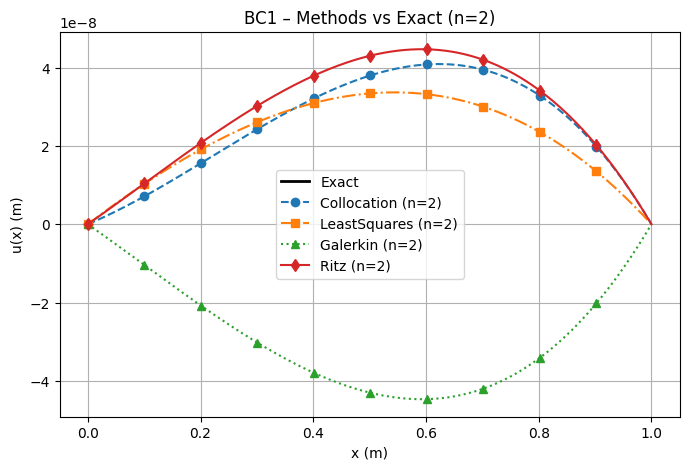

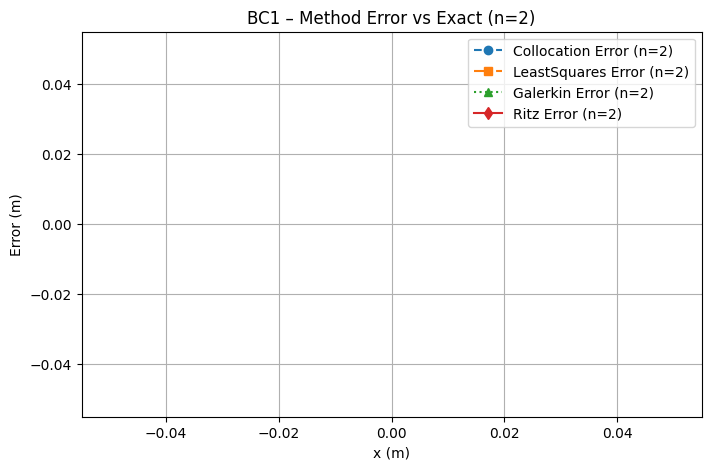

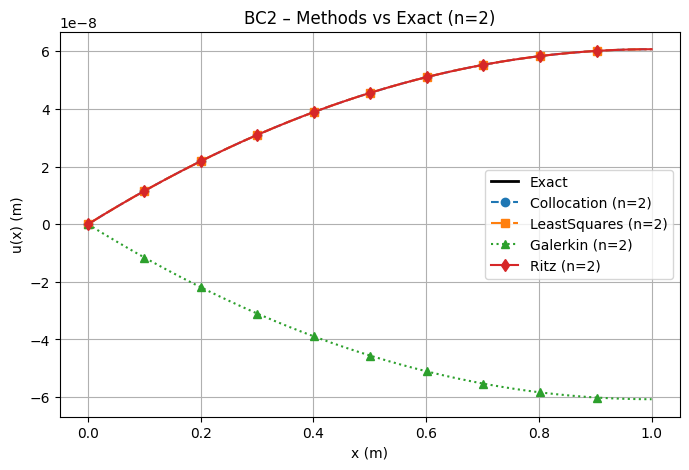

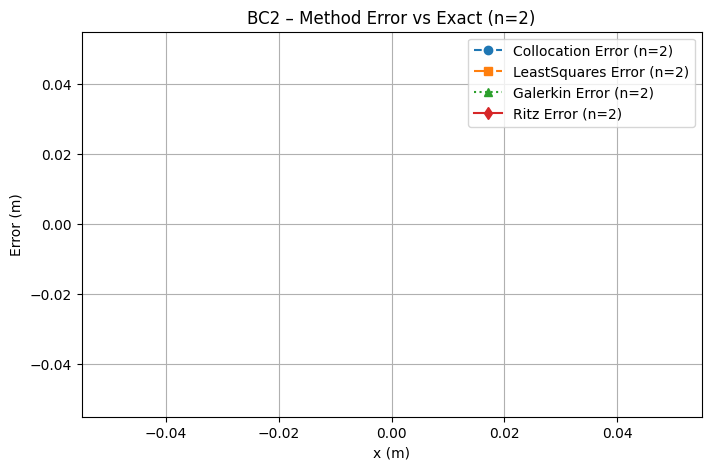

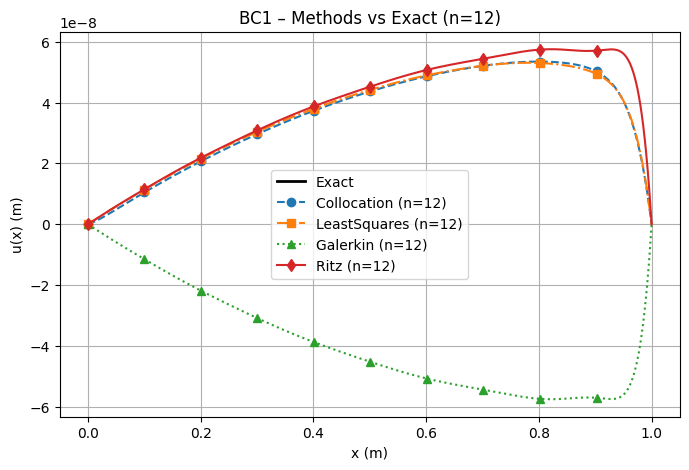

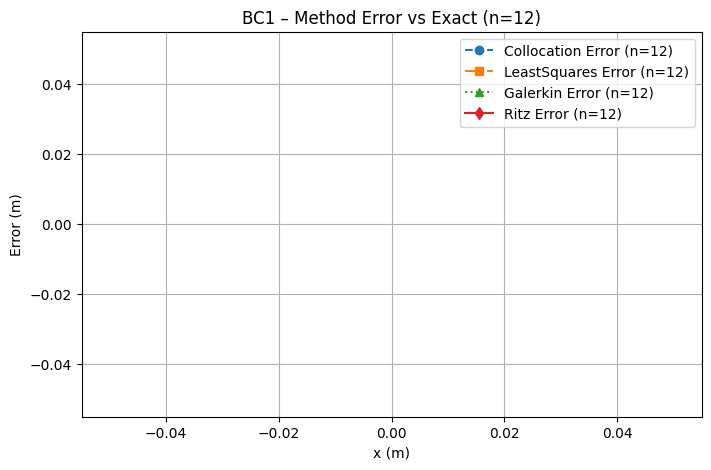

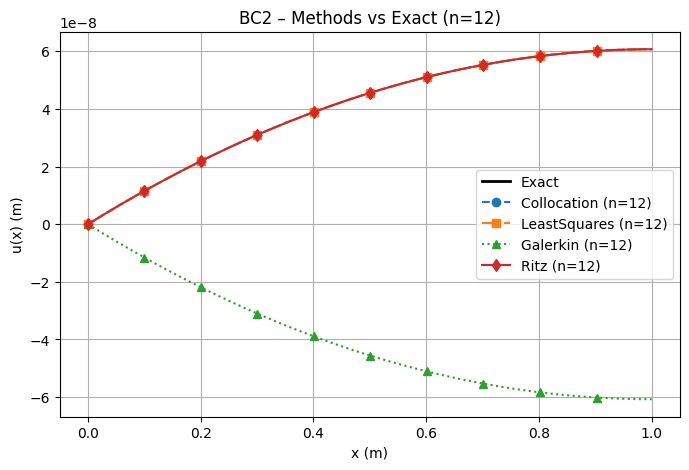

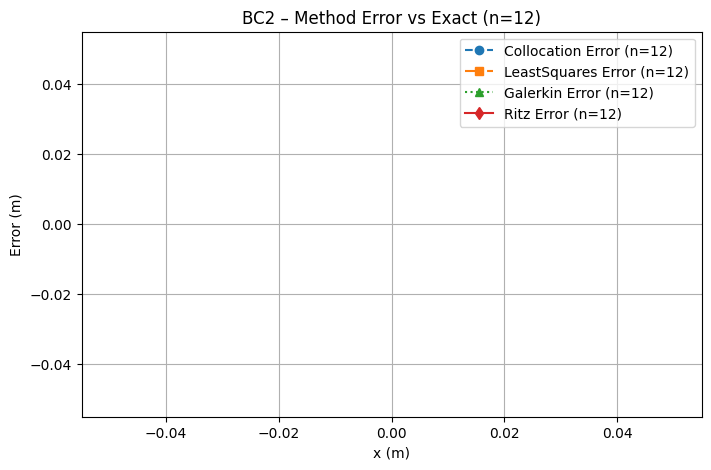

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from numpy.polynomial.legendre import leggauss
from scipy.interpolate import interp1d

# -----------------------------
# Problem parameters
# -----------------------------
E = 210e9
rho = 7800
g = 9.81
x0, x1 = 0.0, 1.0
EPS = 1e-9

def A(x):
    return 100.0 * (x**2 - 2.0*x + 1.0) * 1e-6

def q(x):
    return rho * g * A(x)

def cumtrapz_custom(y, x):
    seg = 0.5 * (y[1:] + y[:-1]) * (x[1:] - x[:-1])
    return np.concatenate(([0.0], np.cumsum(seg)))

def gauss_points_weights(n):
    xs, ws = leggauss(n)
    xs = 0.5*(x1-x0)*xs + 0.5*(x1+x0)
    ws = 0.5*(x1-x0)*ws
    return xs, ws

# -----------------------------
# Exact solution & constants
# -----------------------------
def compute_reference_solution(npoints=5001):
    xs = np.linspace(x0, x1 - EPS, npoints)
    qvals = q(xs)
    Q = cumtrapz_custom(qvals, xs)
    denom = E * A(xs)

    # BC1 constants
    I1 = np.trapz((-Q) / denom, xs)
    I2 = np.trapz(1.0 / denom, xs)
    C1_BC1 = -I1 / I2
    C2_BC1 = 0.0

    uprime_BC1 = (-Q + C1_BC1) / denom
    u_BC1 = cumtrapz_custom(uprime_BC1, xs) + C2_BC1

    # BC2 constants
    C1_BC2 = Q[-1]
    C2_BC2 = 0.0

    uprime_BC2 = (-Q + C1_BC2) / denom
    u_BC2 = cumtrapz_custom(uprime_BC2, xs) + C2_BC2

    print(f"BC1: C1 = {C1_BC1:.6e}, C2 = {C2_BC1:.6e}")
    print(f"BC2: C1 = {C1_BC2:.6e}, C2 = {C2_BC2:.6e}")

    return (interp1d(xs, u_BC1, kind='cubic', fill_value='extrapolate'),
            interp1d(xs, u_BC2, kind='cubic', fill_value='extrapolate'))

# -----------------------------
# Basis functions
# -----------------------------
def basis_BC1(x, n):
    return np.array([ (x*(1.0-x)) * (x**(k-1)) for k in range(1, n+1) ])

def dbasis_BC1(x, n):
    return np.array([ k * x**(k-1) - (k+1) * x**k for k in range(1, n+1) ])

def d2basis_BC1(x, n):
    arr = []
    for k in range(1, n+1):
        if k-2 >= 0:
            term1 = k*(k-1) * x**(k-2)
        else:
            term1 = np.zeros_like(x)
        term2 = (k+1)*k * x**(k-1)
        arr.append(term1 - term2)
    return np.array(arr)

def basis_BC2(x, n):
    return np.array([ x**k for k in range(1, n+1) ])

def dbasis_BC2(x, n):
    return np.array([ k * x**(k-1) for k in range(1, n+1) ])

def d2basis_BC2(x, n):
    arr = []
    for k in range(1, n+1):
        if k-2 >= 0:
            arr.append(k*(k-1) * x**(k-2))
        else:
            arr.append(np.zeros_like(x))
    return np.array(arr)

# -----------------------------
# Methods
# -----------------------------
def assemble_ritz(n, bc):
    phis = basis_BC1 if bc=='BC1' else basis_BC2
    dphis = dbasis_BC1 if bc=='BC1' else dbasis_BC2
    xs, ws = gauss_points_weights(120)
    phi_vals = phis(xs, n)
    dphi_vals = dphis(xs, n)
    K = np.zeros((n, n))
    f = np.zeros(n)
    for i in range(n):
        for j in range(n):
            K[i,j] = np.dot(ws, E * A(xs) * dphi_vals[i,:] * dphi_vals[j,:])
        f[i] = np.dot(ws, q(xs) * phi_vals[i,:])
    return solve(K, f), lambda x: phis(x, n)

def assemble_galerkin(n, bc):
    phis = basis_BC1 if bc=='BC1' else basis_BC2
    dphis = dbasis_BC1 if bc=='BC1' else dbasis_BC2
    xs, ws = gauss_points_weights(120)
    phi_vals = phis(xs, n)
    dphi_vals = dphis(xs, n)
    A_mat = np.zeros((n,n))
    b_vec = np.zeros(n)
    for j in range(n):
        for i in range(n):
            A_mat[j,i] = np.dot(ws, E * A(xs) * dphi_vals[j,:] * dphi_vals[i,:])
        b_vec[j] = - np.dot(ws, phi_vals[j,:] * q(xs))
    return solve(A_mat, b_vec), lambda x: phis(x, n)

def assemble_least_squares(n, bc):
    phis = basis_BC1 if bc=='BC1' else basis_BC2
    dphis = dbasis_BC1 if bc=='BC1' else dbasis_BC2
    d2phis = d2basis_BC1 if bc=='BC1' else d2basis_BC2
    xs, ws = gauss_points_weights(120)
    dphi_vals = dphis(xs, n)
    d2phi_vals = d2phis(xs, n)
    Aprime = (200.0*(xs - 1.0)) * 1e-6
    D_dphi = E * (Aprime * dphi_vals + A(xs) * d2phi_vals)
    M = np.zeros((n,n))
    rhs = np.zeros(n)
    for i in range(n):
        for j in range(n):
            M[i,j] = np.dot(ws, D_dphi[i,:] * D_dphi[j,:])
        rhs[i] = - np.dot(ws, q(xs) * D_dphi[i,:])
    return solve(M, rhs), lambda x: phis(x, n)

def assemble_collocation(n, bc):
    xs = np.linspace(x0 + EPS, x1 - EPS, n+2)[1:-1]
    if bc=='BC1':
        dphi_vals = dbasis_BC1(xs, n)
        d2phi_vals = d2basis_BC1(xs, n)
        phis = lambda xx: basis_BC1(xx, n)
    else:
        dphi_vals = dbasis_BC2(xs, n)
        d2phi_vals = d2basis_BC2(xs, n)
        phis = lambda xx: basis_BC2(xx, n)
    Aprime = (200.0*(xs - 1.0)) * 1e-6
    D_dphi = E * (Aprime * dphi_vals + A(xs) * d2phi_vals)
    G = D_dphi.T
    rhs = - q(xs)
    return solve(G, rhs), phis

def eval_u(a, phis_func, xvals):
    return np.dot(a, phis_func(xvals))

def error_vs_exact(a, phis_func, u_ref, xvals):
    return eval_u(a, phis_func, xvals) - u_ref(xvals)

# -----------------------------
# Main
# -----------------------------
u_ref_BC1, u_ref_BC2 = compute_reference_solution()
methods = ['Collocation', 'LeastSquares', 'Galerkin', 'Ritz']
linestyles = ['--', '-.', ':', '-']
markers = ['o', 's', '^', 'd']
x_plot = np.linspace(x0, x1 - EPS, 400)

for n in [2, 12]:
    for bc_label, uref in [('BC1', u_ref_BC1), ('BC2', u_ref_BC2)]:
        # 1) Converged solutions
        plt.figure(figsize=(8,5))
        plt.plot(x_plot, uref(x_plot), 'k-', linewidth=2, label='Exact')
        for i, m in enumerate(methods):
            if m=='Collocation':
                a, phis = assemble_collocation(n, bc_label)
            elif m=='LeastSquares':
                a, phis = assemble_least_squares(n, bc_label)
            elif m=='Galerkin':
                a, phis = assemble_galerkin(n, bc_label)
            else:
                a, phis = assemble_ritz(n, bc_label)
            plt.plot(x_plot, eval_u(a, phis, x_plot),
                     linestyle=linestyles[i], marker=markers[i], markevery=40,
                     label=f"{m} (n={n})")
        plt.xlabel("x (m)")
        plt.ylabel("u(x) (m)")
        plt.title(f"{bc_label} – Methods vs Exact (n={n})")
        plt.legend()
        plt.grid(True)
        plt.show()

        # 2) Error vs exact
        plt.figure(figsize=(8,5))
        for i, m in enumerate(methods):
            if m=='Collocation':
                a, phis = assemble_collocation(n, bc_label)
            elif m=='LeastSquares':
                a, phis = assemble_least_squares(n, bc_label)
            elif m=='Galerkin':
                a, phis = assemble_galerkin(n, bc_label)
            else:
                a, phis = assemble_ritz(n, bc_label)
            plt.plot(x_plot, error_vs_exact(a, phis, uref, x_plot),
                     linestyle=linestyles[i], marker=markers[i], markevery=40,
                     label=f"{m} Error (n={n})")
        plt.xlabel("x (m)")
        plt.ylabel("Error (m)")
        plt.title(f"{bc_label} – Method Error vs Exact (n={n})")
        plt.legend()
        plt.grid(True)
        plt.show()


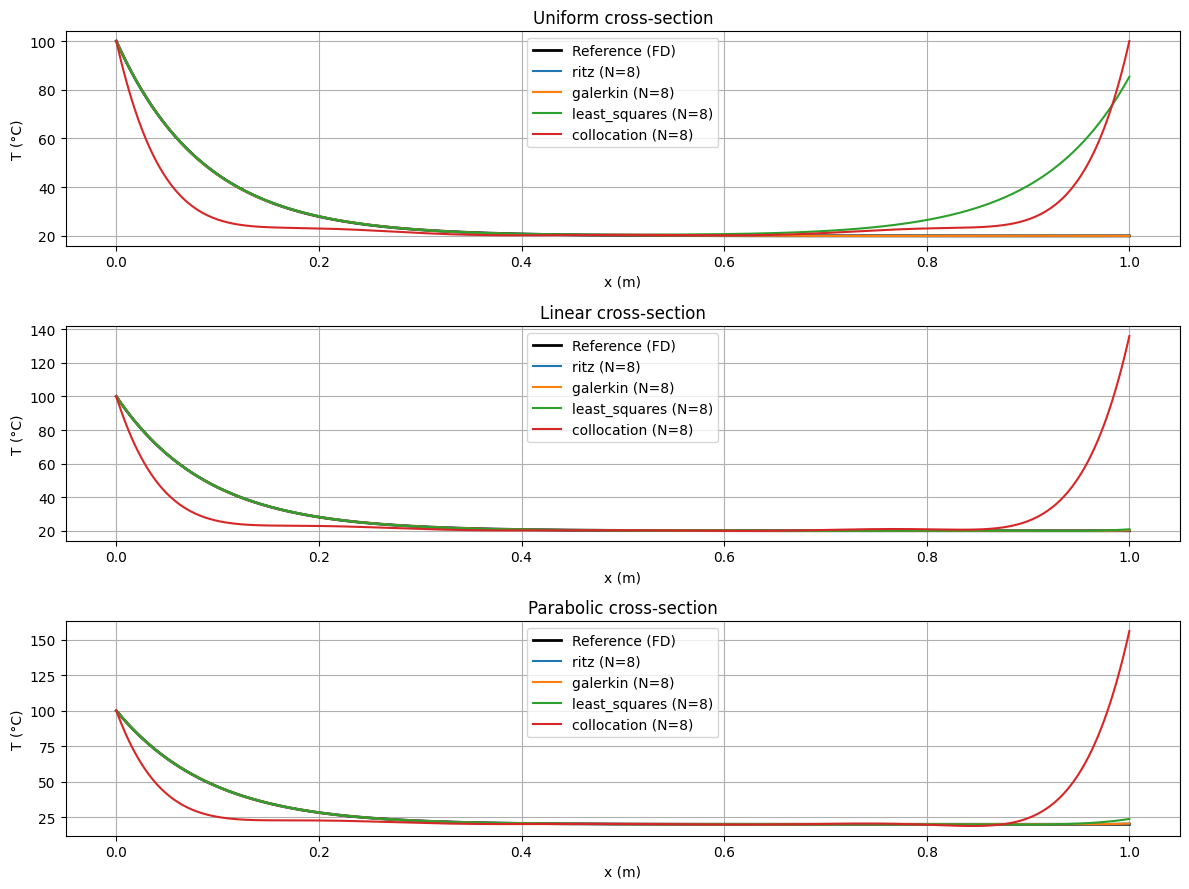


Two-term (N=2) coefficients for T(x) = T0 + a1*phi1 + a2*phi2

--- Uniform ---
ritz: a = [-291.02412021  229.86687755]
galerkin: a = [-291.02412021  229.86687755]
least_squares: a = [-311.45314622  263.16583673]
collocation: a = [-337.236376  337.236376]

--- Linear ---
ritz: a = [-330.40995659  290.65875505]
galerkin: a = [-330.40995659  290.65875505]
least_squares: a = [-378.62206481  374.25424687]
collocation: a = [-347.61501635  351.58282625]

--- Parabolic ---
ritz: a = [-362.41465265  346.80828005]
galerkin: a = [-362.41465265  346.80828005]
least_squares: a = [-452.47665614  527.71463241]
collocation: a = [-353.47020388  359.99982   ]



/tmp/ipython-input-2255530590.py:248: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  err_L2 += np.sqrt(np.trapz(e*e, xr))
/usr/local/lib/python3.11/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.30397e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.11/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.73499e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.11/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.64464e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


IndexError: index 0 is out of bounds for axis 0 with size 0

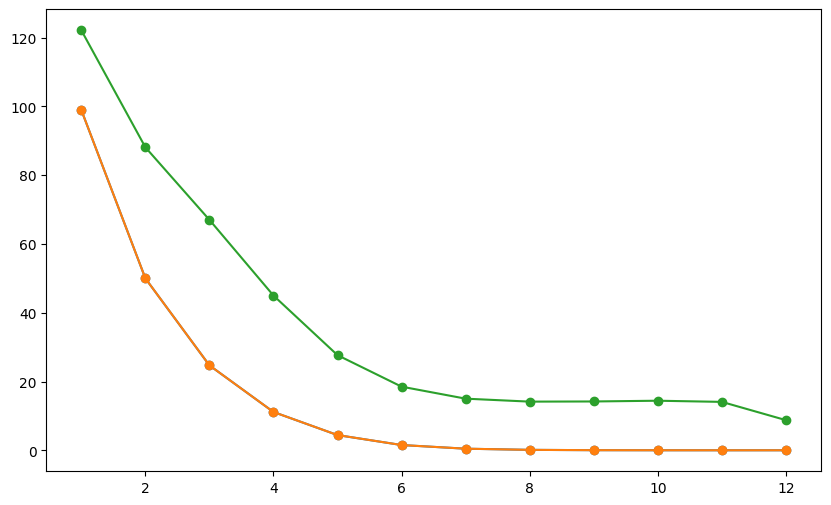

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from numpy.polynomial.legendre import leggauss

# -----------------------------
# Physical / problem parameters
# -----------------------------
k = 300.0            # W / (m C)
h = 100.0            # W / (m^2 C)
T_inf = 20.0         # C
T0_val = 100.0       # temperature at x=0 (C)
L = 1.0              # m  (100 cm)
# Note: given A in mm^2 in problem statement, convert -> m^2 (100 mm^2 = 100e-6 m^2)

# Quadrature helper
def gauss_points_weights(nq, x0=0.0, x1=1.0):
    xs, ws = leggauss(nq)
    xs = 0.5*(x1-x0)*xs + 0.5*(x1+x0)
    ws = 0.5*(x1-x0)*ws
    return xs, ws

# Area definitions (return A in m^2)
def A_uniform(x):
    return 100.0e-6 * np.ones_like(x)

def A_linear(x):
    return 100.0e-6 * (1.0 - x/L)

def A_parabolic(x):
    # 100 * [ (x/L)^2 - 2(x/L) + 1 ] mm^2
    xi = x / L
    return 100.0e-6 * (xi*xi - 2.0*xi + 1.0)

# Perimeter for square cross-section: P = 4 * sqrt(A) (since A = a^2 -> a = sqrt(A))
def P_from_A(Avals):
    return 4.0 * np.sqrt(Avals)

# -----------------------------
# Reference solution: finite difference
# -----------------------------
def reference_fd(Afunc, Nx=500):
    # second-order FD for -d/dx(k A dT/dx) + h P (T - T_inf) = 0
    x = np.linspace(0.0, L, Nx+1)
    dx = x[1] - x[0]
    Avals = Afunc(x)
    Pvals = P_from_A(Avals)
    # Build tridiagonal matrix for interior nodes 1..N-1, apply BCs:
    N = Nx
    diag = np.zeros(N+1)
    low = np.zeros(N)
    high = np.zeros(N)
    rhs = np.zeros(N+1)
    # index 0 is Dirichlet T(0)=T0_val
    diag[0] = 1.0
    rhs[0] = T0_val
    # interior nodes i = 1..N-1
    for i in range(1, N):
        xm = x[i] - dx/2
        xp = x[i] + dx/2
        # use harmonic-like average for kA at faces
        A_m = Avals[i-1]
        A_p = Avals[i]
        kA_m = k * ( (Avals[i] + Avals[i-1]) / 2.0 )
        kA_p = k * ( (Avals[i] + Avals[i+1]) / 2.0 ) if i+1 <= N else k * Avals[i]
        a_w = kA_m / dx**2
        a_e = kA_p / dx**2
        a_p = a_w + a_e + h * Pvals[i]
        diag[i] = a_p
        low[i-1] = -a_w
        high[i] = -a_e
        rhs[i] = h * Pvals[i] * T_inf
    # last node i = N (tip): Neumann k A(L) T'(L) = 0 -> approximate with backward diff: T'(L) ~ (T_N - T_{N-1})/dx = 0 => T_N = T_{N-1}
    # Implement last equation: T_N - T_{N-1} = 0
    diag[N] = 1.0
    low[N-1] = -1.0
    rhs[N] = 0.0
    # assemble tri diag into full matrix (dense is OK for Nx ~ few hundreds)
    M = np.zeros((N+1, N+1))
    for i in range(N+1):
        M[i,i] = diag[i]
    for i in range(N):
        M[i+1,i] = low[i]
        M[i,i+1] = high[i]
    T = solve(M, rhs)
    return x, T

# -----------------------------
# Basis functions (they satisfy phi(0)=0)
# phi_k(x) = (x/L)**k
# -----------------------------
def basis(x, n):
    # returns array shape (n, len(x))
    xs = np.atleast_1d(x)
    return np.vstack([ (xs/L)**(k+1) for k in range(n) ])

def dbasis(x, n):
    xs = np.atleast_1d(x)
    return np.vstack([ (k+1)/L * (xs/L)**(k) for k in range(n) ])

# helper eval
def eval_u_from_coeffs(a, x):
    # T(x) = T0_val + sum a_i * phi_i(x)
    phis = basis(x, len(a))
    return T0_val + np.dot(a, phis)

# -----------------------------
# Assemble methods (general)
# -----------------------------
def assemble_ritz(n, Afunc, nq=120):
    # T = T0 + sum a_i phi_i
    xs, ws = gauss_points_weights(nq, 0.0, L)
    Avals = Afunc(xs)
    Pvals = P_from_A(Avals)
    phis = basis(xs, n)
    dphis = dbasis(xs, n)
    # stiffness matrix K_ij = ∫ (k A dphi_i dphi_j + h P phi_i phi_j) dx
    K = np.zeros((n,n))
    F = np.zeros(n)
    for i in range(n):
        for j in range(n):
            K[i,j] = np.dot(ws, (k * Avals * dphis[i,:] * dphis[j,:] + h * Pvals * phis[i,:] * phis[j,:]))
        # RHS: ∫ h P T_inf * phi_i dx - ∫ (k A dT0 dphi_i + h P T0 phi_i) dx
        # Here dT0 = 0 (T0 constant = T0_val). So RHS reduces:
        F[i] = np.dot(ws, h * Pvals * T_inf * phis[i,:]) - np.dot(ws, h * Pvals * T0_val * phis[i,:])
        # combine: F[i] = np.dot(ws, h * Pvals * (T_inf - T0_val) * phis[i,:])
    a = solve(K, F)
    return a

def assemble_galerkin(n, Afunc, nq=120):
    # Galerkin weak form gives same linear system for symmetric problem
    return assemble_ritz(n, Afunc, nq=nq)

def assemble_least_squares(n, Afunc, nq=150):
    # Minimize integral of residual^2, residual R = -d/dx(k A T') + h P (T - T_inf)
    xs, ws = gauss_points_weights(nq, 0.0, L)
    Avals = Afunc(xs)
    Pvals = P_from_A(Avals)
    phis = basis(xs, n)
    dphis = dbasis(xs, n)
    # compute operator applied to phi: D(phi) = -d/dx(k A dphi/dx) + h P phi
    # Use numerical derivative for d/dx(k A dphi/dx)
    # dphi/dx known analytically; compute kA * dphi/dx then differentiate numerically
    kA_dphi = k * Avals * dphis
    # numerical derivative w.r.t x using central differences on quadrature points (approx)
    # We'll approximate derivative using np.gradient over xs
    D_phi = - np.gradient(kA_dphi, xs, axis=1) + h * Pvals * phis
    # D_phi shape (n, nq)
    M = np.zeros((n,n))
    rhs = np.zeros(n)
    # Residual produced by T0: R0 = -d/dx(kA dT0/dx) + h P (T0 - T_inf)
    # dT0/dx = 0, so R0 = h P (T0 - T_inf)
    R0 = h * Pvals * (T0_val - T_inf)
    for i in range(n):
        for j in range(n):
            M[i,j] = np.dot(ws, D_phi[i,:] * D_phi[j,:])
        rhs[i] = - np.dot(ws, D_phi[i,:] * R0)   # because D(sum a phi) + R0 = 0 -> normal eqn
    a = solve(M, rhs)
    return a

def assemble_collocation(n, Afunc):
    # choose n collocation points interior (exclude x=0 and x=L)
    xs = np.linspace(0.0 + 1e-6, L - 1e-6, n+2)[1:-1]
    Avals = Afunc(xs)
    Pvals = P_from_A(Avals)
    phis = basis(xs, n)
    dphis = dbasis(xs, n)
    # At each collocation pt, residual R = -d/dx(kA dT/dx) + hP (T - T_inf) = 0
    # compute numeric derivative for kA d/dx phi
    kA_dphi = k * Avals * dphis
    # numerical derivative w.r.t x at collocation points
    # For small n the collocation derivative via gradient on the set xs is okay
    d_kA_dphi = np.gradient(kA_dphi, xs, axis=1)
    # Residual for basis: D_phi = - d_kA_dphi + hP * phi
    D_phi = - d_kA_dphi + h * Pvals * phis
    # Residual from T0: R0 = hP (T0 - T_inf)
    R0 = h * Pvals * (T0_val - T_inf)
    # Solve D_phi @ a = -R0
    a = solve(D_phi.T, -R0)
    return a

# -----------------------------
# Plotting & convergence runs
# -----------------------------
methods = {
    'ritz': assemble_ritz,
    'galerkin': assemble_galerkin,
    'least_squares': assemble_least_squares,
    'collocation': assemble_collocation
}

A_funcs = {
    'Uniform': A_uniform,
    'Linear': A_linear,
    'Parabolic': A_parabolic
}

# resolution for plotting
x_plot = np.linspace(0.0, L, 400)

# Compute reference solutions for each A
ref_sols = {}
for name, Af in A_funcs.items():
    xr, Tr = reference_fd(Af, Nx=800)    # fine FD
    ref_sols[name] = (xr, Tr)

# Example: compare methods with N = 8
N_plot = 8
plt.figure(figsize=(12,9))
for idx, (name, Af) in enumerate(A_funcs.items(), 1):
    plt.subplot(3,1,idx)
    xr, Tr = ref_sols[name]
    plt.plot(xr, Tr, 'k-', lw=2, label='Reference (FD)')
    for mname, assembler in methods.items():
        a = assembler(N_plot, Af)
        Tapprox = eval_u_from_coeffs(a, x_plot)
        plt.plot(x_plot, Tapprox, label=f"{mname} (N={N_plot})")
    plt.title(f"{name} cross-section")
    plt.xlabel("x (m)")
    plt.ylabel("T (°C)")
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

# Print two-term coefficients (N=2) for each method & area
print("\nTwo-term (N=2) coefficients for T(x) = T0 + a1*phi1 + a2*phi2\n")
for name, Af in A_funcs.items():
    print(f"--- {name} ---")
    for mname, assembler in methods.items():
        a = assembler(2, Af)
        print(f"{mname}: a = {a}")
    print()

# Convergence: compute L2 error vs N for N=1..12
Ns = list(range(1,13))
plt.figure(figsize=(10,6))
for mname, assembler in methods.items():
    err_list = []
    for N in Ns:
        err_max = 0.0
        err_L2 = 0.0
        for name, Af in A_funcs.items():
            xr, Tr = ref_sols[name]
            a = assembler(N, Af)
            Tapprox = eval_u_from_coeffs(a, xr)
            e = Tr - Tapprox
            err_L2 += np.sqrt(np.trapz(e*e, xr))
        # accumulate L2 over three areas to get a single convergence curve
        err_list.append(err_L2)
    plt.plot(Ns, err_list, marker='o', label=mname)
plt.yscale('log')
plt.xlabel("Number of basis terms N")
plt.ylabel("Aggregated L2 error (three cross-sections)")
plt.title("Convergence of methods (aggregated over cross-sections)")
plt.grid(True)
plt.legend()
plt.show()

# Show final comparison of converged results (N=12) on a single figure per area
N_conv = 12
for name, Af in A_funcs.items():
    plt.figure(figsize=(8,5))
    xr, Tr = ref_sols[name]
    plt.plot(xr, Tr, 'k-', lw=2, label='Reference (FD)')
    for mname, assembler in methods.items():
        a = assembler(N_conv, Af)
        Tapprox = eval_u_from_coeffs(a, x_plot)
        plt.plot(x_plot, Tapprox, label=f"{mname} (N={N_conv})")
    plt.title(f"Converged comparison for {name} cross-section")
    plt.xlabel("x (m)")
    plt.ylabel("T (°C)")
    plt.legend()
    plt.grid(True)
    plt.show()

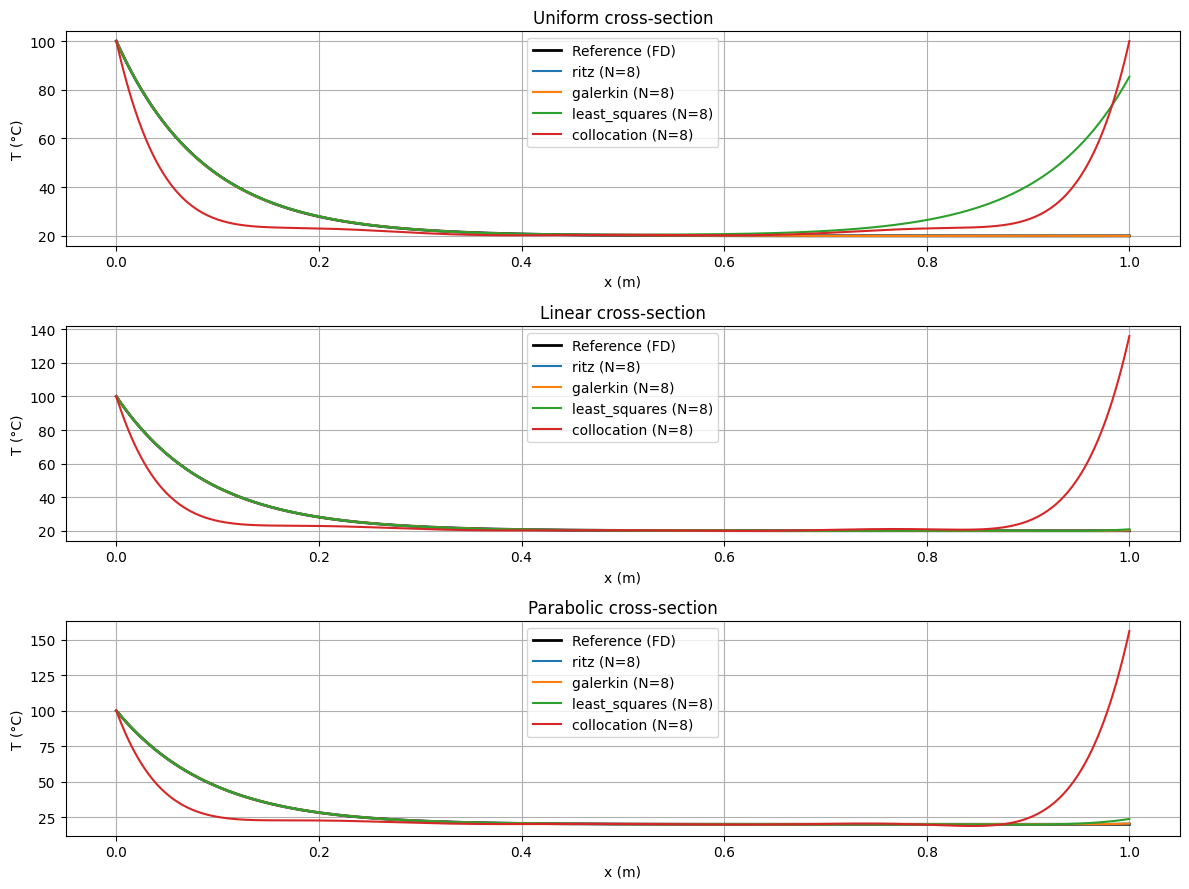

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from numpy.polynomial.legendre import leggauss

# -----------------------------
# Physical / problem parameters
# -----------------------------
k = 300.0            # W / (m C)
h = 100.0            # W / (m^2 C)
T_inf = 20.0         # C
T0_val = 100.0       # temperature at x=0 (C)
L = 1.0              # m

# Quadrature helper
def gauss_points_weights(nq, x0=0.0, x1=1.0):
    xs, ws = leggauss(nq)
    xs = 0.5*(x1-x0)*xs + 0.5*(x1+x0)
    ws = 0.5*(x1-x0)*ws
    return xs, ws

# Area definitions (return A in m^2)
def A_uniform(x):
    return 100.0e-6 * np.ones_like(x)

def A_linear(x):
    return 100.0e-6 * (1.0 - x/L)

def A_parabolic(x):
    xi = x / L
    return 100.0e-6 * (xi**2 - 2.0*xi + 1.0)

# Perimeter for square cross-section
def P_from_A(Avals):
    return 4.0 * np.sqrt(Avals)

# -----------------------------
# Reference solution: finite difference
# -----------------------------
def reference_fd(Afunc, Nx=500):
    # Nx intervals, Nx+1 points
    x = np.linspace(0.0, L, Nx+1)
    dx = x[1] - x[0]
    Avals = Afunc(x)
    Pvals = P_from_A(Avals)

    # System size: Nx+1
    diag = np.zeros(Nx+1)
    low = np.zeros(Nx)    # subdiagonal
    high = np.zeros(Nx)   # superdiagonal
    rhs = np.zeros(Nx+1)

    # BC at x=0: Dirichlet
    diag[0] = 1.0
    rhs[0] = T0_val

    # Interior nodes
    for i in range(1, Nx):
        kA_w = k * 0.5 * (Avals[i] + Avals[i-1])
        kA_e = k * 0.5 * (Avals[i] + Avals[i+1])
        a_w = kA_w / dx**2
        a_e = kA_e / dx**2
        diag[i] = a_w + a_e + h * Pvals[i]
        low[i-1] = -a_w
        high[i] = -a_e
        rhs[i] = h * Pvals[i] * T_inf

    # BC at x=L: insulated tip (Neumann)
    diag[Nx] = 1.0
    low[Nx-1] = -1.0
    rhs[Nx] = 0.0

    # Assemble dense matrix
    M = np.zeros((Nx+1, Nx+1))
    for i in range(Nx+1):
        M[i,i] = diag[i]
    for i in range(Nx):
        M[i+1,i] = low[i]
        M[i,i+1] = high[i]

    T = solve(M, rhs)
    return x, T

# -----------------------------
# Basis functions
# -----------------------------
def basis(x, n):
    xs = np.atleast_1d(x)
    return np.vstack([(xs/L)**(k+1) for k in range(n)])

def dbasis(x, n):
    xs = np.atleast_1d(x)
    return np.vstack([(k+1)/L * (xs/L)**k for k in range(n)])

def eval_u_from_coeffs(a, x):
    phis = basis(x, len(a))
    return T0_val + np.dot(a, phis)

# -----------------------------
# Methods
# -----------------------------
def assemble_ritz(n, Afunc, nq=120):
    xs, ws = gauss_points_weights(nq, 0.0, L)
    Avals = Afunc(xs)
    Pvals = P_from_A(Avals)
    phis = basis(xs, n)
    dphis = dbasis(xs, n)
    K = np.zeros((n,n))
    F = np.zeros(n)
    for i in range(n):
        for j in range(n):
            K[i,j] = np.dot(ws, (k*Avals*dphis[i,:]*dphis[j,:] + h*Pvals*phis[i,:]*phis[j,:]))
        F[i] = np.dot(ws, h*Pvals*(T_inf - T0_val)*phis[i,:])
    a = solve(K, F)
    return a

def assemble_galerkin(n, Afunc, nq=120):
    return assemble_ritz(n, Afunc, nq)

def assemble_least_squares(n, Afunc, nq=150):
    xs, ws = gauss_points_weights(nq, 0.0, L)
    Avals = Afunc(xs)
    Pvals = P_from_A(Avals)
    phis = basis(xs, n)
    dphis = dbasis(xs, n)
    kA_dphi = k * Avals * dphis
    d_kA_dphi = np.gradient(kA_dphi, xs, axis=1)
    D_phi = -d_kA_dphi + h * Pvals * phis
    R0 = h * Pvals * (T0_val - T_inf)
    M = np.zeros((n,n))
    rhs = np.zeros(n)
    for i in range(n):
        for j in range(n):
            M[i,j] = np.dot(ws, D_phi[i,:]*D_phi[j,:])
        rhs[i] = -np.dot(ws, D_phi[i,:]*R0)
    a = solve(M, rhs)
    return a

def assemble_collocation(n, Afunc):
    xs = np.linspace(0.0+1e-6, L-1e-6, n+2)[1:-1]
    Avals = Afunc(xs)
    Pvals = P_from_A(Avals)
    phis = basis(xs, n)
    dphis = dbasis(xs, n)
    kA_dphi = k * Avals * dphis
    d_kA_dphi = np.gradient(kA_dphi, xs, axis=1)
    D_phi = -d_kA_dphi + h * Pvals * phis
    R0 = h * Pvals * (T0_val - T_inf)
    a = solve(D_phi.T, -R0)
    return a

# -----------------------------
# Run & plot
# -----------------------------
methods = {
    'ritz': assemble_ritz,
    'galerkin': assemble_galerkin,
    'least_squares': assemble_least_squares,
    'collocation': assemble_collocation
}

A_funcs = {
    'Uniform': A_uniform,
    'Linear': A_linear,
    'Parabolic': A_parabolic
}

x_plot = np.linspace(0.0, L, 400)

# Reference FD solutions
ref_sols = {}
for name, Af in A_funcs.items():
    xr, Tr = reference_fd(Af, Nx=800)
    ref_sols[name] = (xr, Tr)

# Compare methods for N=8
N_plot = 8
plt.figure(figsize=(12,9))
for idx, (name, Af) in enumerate(A_funcs.items(), 1):
    plt.subplot(3,1,idx)
    xr, Tr = ref_sols[name]
    plt.plot(xr, Tr, 'k-', lw=2, label='Reference (FD)')
    for mname, assembler in methods.items():
        a = assembler(N_plot, Af)
        Tapprox = eval_u_from_coeffs(a, x_plot)
        plt.plot(x_plot, Tapprox, label=f"{mname} (N={N_plot})")
    plt.title(f"{name} cross-section")
    plt.xlabel("x (m)")
    plt.ylabel("T (°C)")
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()


Computed FD reference for Uniform (Nx=1000)
Computed FD reference for Linear (Nx=1000)
Computed FD reference for Parabolic (Nx=1000)


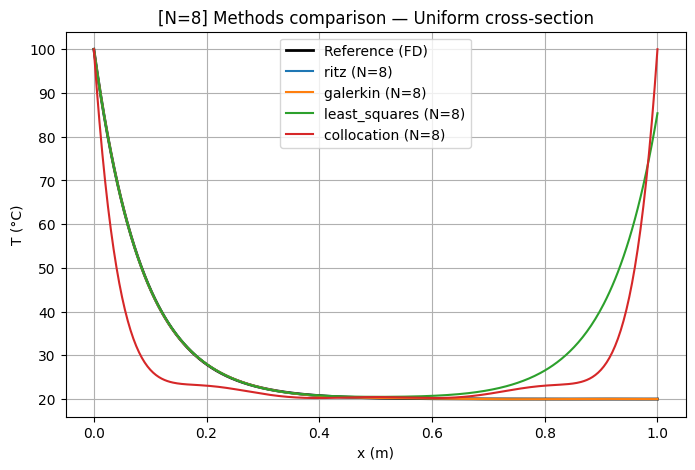

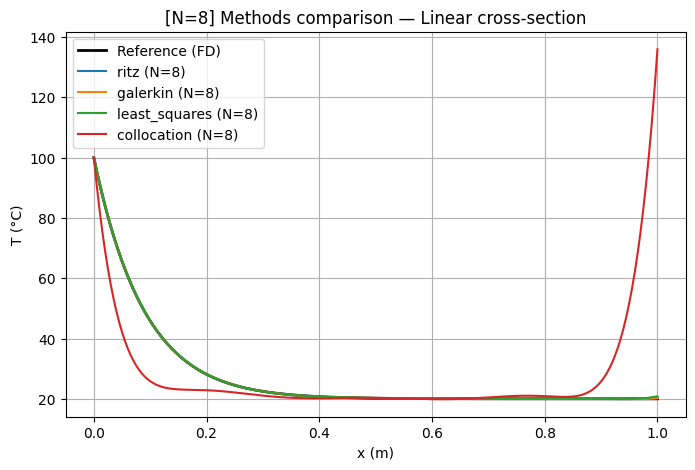

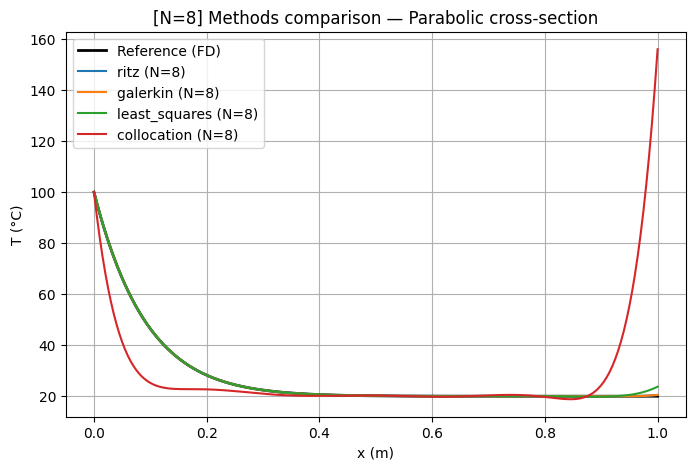


Two-term (N=2) coefficients (T(x) = T0 + a1*phi1 + a2*phi2):

--- Uniform cross-section ---
ritz           : a = [-291.02412021  229.86687755]
galerkin       : a = [-291.02412021  229.86687755]
least_squares  : a = [-311.45314622  263.16583673]
collocation    : a = [-337.23653238  337.23653238]

--- Linear cross-section ---
ritz           : a = [-330.4099913   290.65882024]
galerkin       : a = [-330.4099913   290.65882024]
least_squares  : a = [-378.62207346  374.25426279]
collocation    : a = [-347.61518273  351.58299575]

--- Parabolic cross-section ---
ritz           : a = [-362.41465265  346.80828005]
galerkin       : a = [-362.41465265  346.80828005]
least_squares  : a = [-452.47841719  527.71460554]
collocation    : a = [-353.47037314  359.9999982 ]



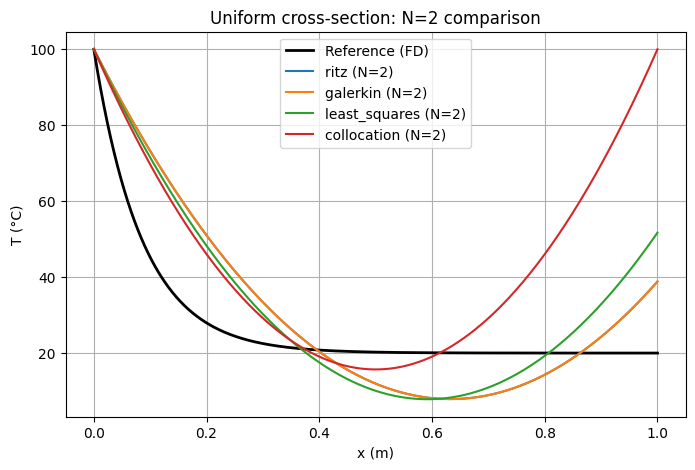

/usr/local/lib/python3.11/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.33508e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


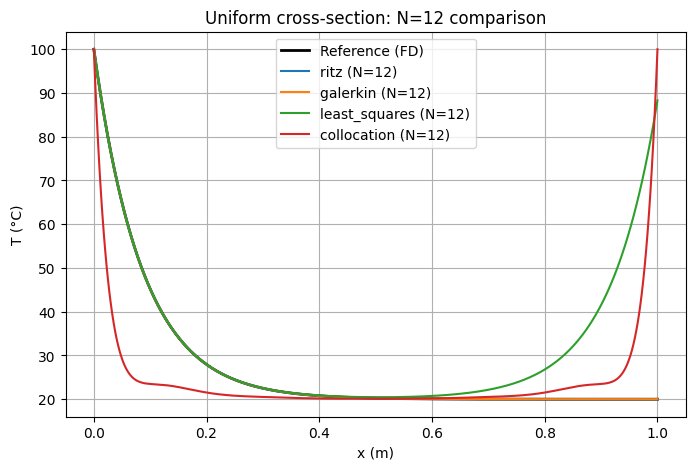

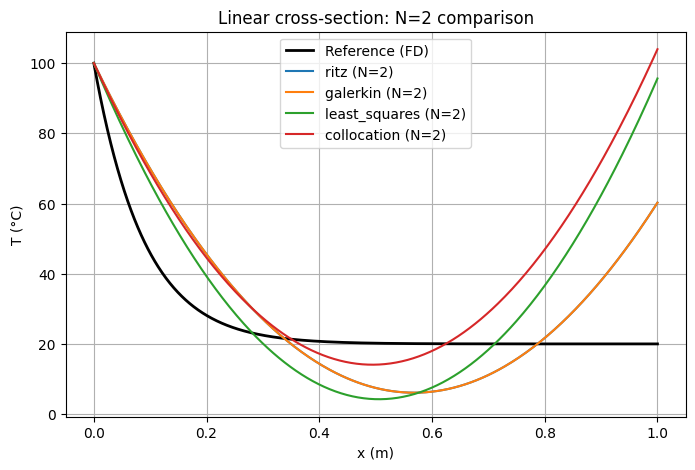

/usr/local/lib/python3.11/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.58288e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


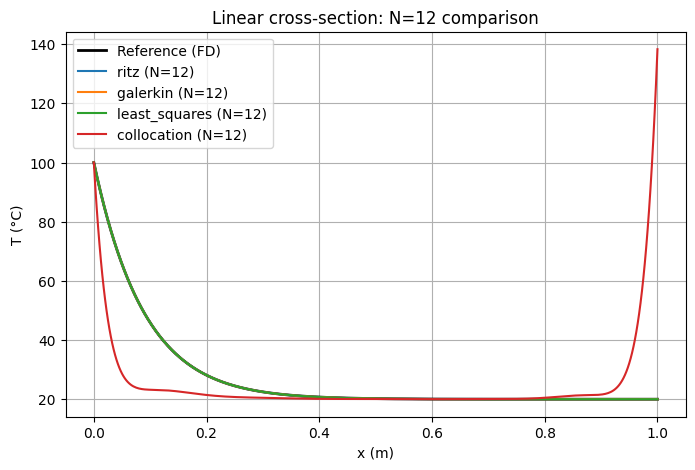

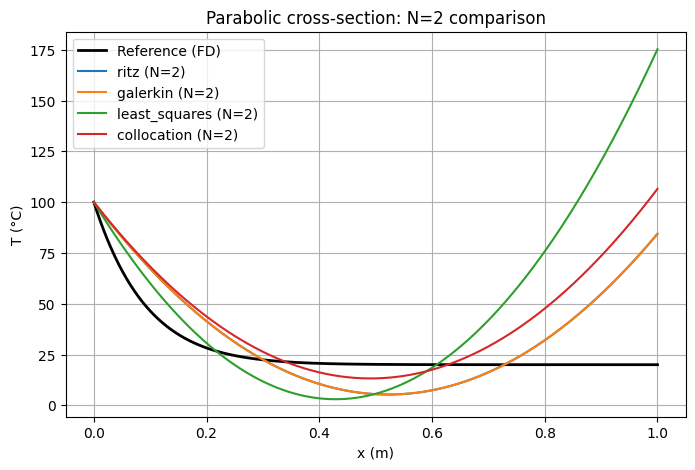

/usr/local/lib/python3.11/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.6615e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


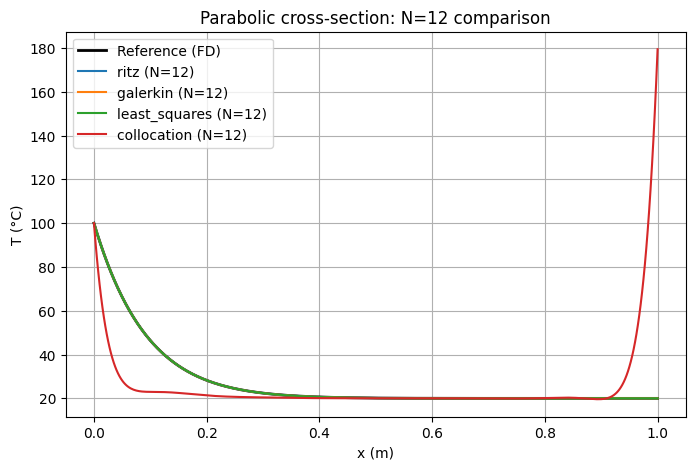

/tmp/ipython-input-3670983065.py:271: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  L2 = np.sqrt(np.trapz(e*e, xr))


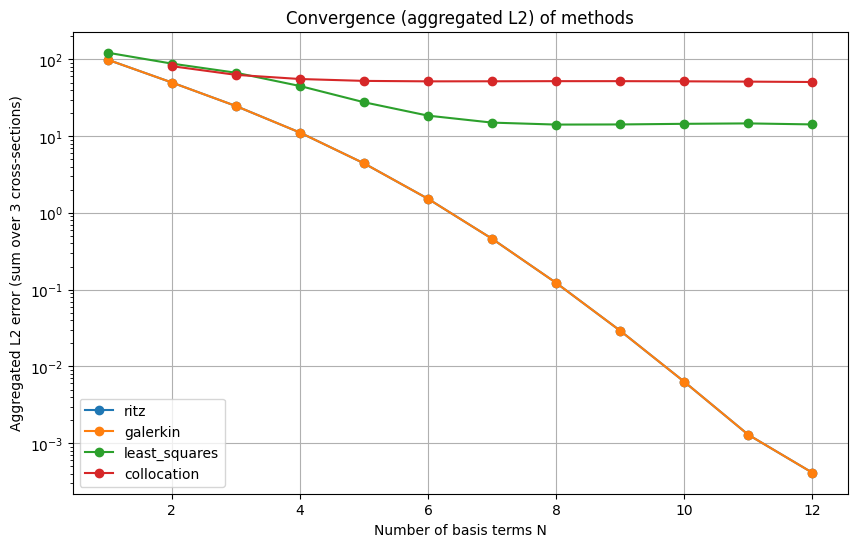


Summary: L2 errors (per area & method) for N=2 and N=12

--- Uniform ---
 N = 2:
   ritz           : L2 = 1.409754e+01, max_abs = 2.837903e+01
   galerkin       : L2 = 1.409754e+01, max_abs = 2.837903e+01
   least_squares  : L2 = 1.451266e+01, max_abs = 3.171114e+01
   collocation    : L2 = 2.648003e+01, max_abs = 7.999844e+01
 N = 12:
   ritz           : L2 = 1.585643e-04, max_abs = 3.317982e-04
   galerkin       : L2 = 1.585643e-04, max_abs = 3.317982e-04
   least_squares  : L2 = 1.421532e+01, max_abs = 6.830613e+01
   collocation    : L2 = 1.350953e+01, max_abs = 7.999845e+01

--- Linear ---
 N = 2:
   ritz           : L2 = 1.541824e+01, max_abs = 4.024867e+01
   galerkin       : L2 = 1.541824e+01, max_abs = 4.024867e+01
   least_squares  : L2 = 2.365457e+01, max_abs = 7.563203e+01
   collocation    : L2 = 2.726977e+01, max_abs = 8.396765e+01
 N = 12:
   ritz           : L2 = 1.347436e-04, max_abs = 9.717044e-04
   galerkin       : L2 = 1.347436e-04, max_abs = 9.717044e-04
   least

/tmp/ipython-input-3670983065.py:301: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  L2 = np.sqrt(np.trapz(e*e, xr))


   ritz           : L2 = 2.048396e+01, max_abs = 6.439363e+01
   galerkin       : L2 = 2.048396e+01, max_abs = 6.439363e+01
   least_squares  : L2 = 4.995653e+01, max_abs = 1.552362e+02
   collocation    : L2 = 2.784555e+01, max_abs = 8.652962e+01
 N = 12:
   ritz           : L2 = 1.192062e-04, max_abs = 1.302237e-03
   galerkin       : L2 = 1.192062e-04, max_abs = 1.302237e-03
   least_squares  : L2 = 3.237296e-03, max_abs = 8.917016e-03
   collocation    : L2 = 2.049566e+01, max_abs = 1.594286e+02

Done.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from numpy.polynomial.legendre import leggauss

# -----------------------------
# Physical / problem parameters
# -----------------------------
k = 300.0            # W / (m C)
h = 100.0            # W / (m^2 C)
T_inf = 20.0         # C
T0_val = 100.0       # temperature at x=0 (C)
L = 1.0              # m (100 cm)

# -----------------------------
# Quadrature helper
# -----------------------------
def gauss_points_weights(nq, x0=0.0, x1=1.0):
    xs, ws = leggauss(nq)
    xs = 0.5*(x1-x0)*xs + 0.5*(x1+x0)
    ws = 0.5*(x1-x0)*ws
    return xs, ws

# -----------------------------
# Area definitions (m^2)
# -----------------------------
def A_uniform(x):
    return 100.0e-6 * np.ones_like(x)

def A_linear(x):
    return 100.0e-6 * (1.0 - x / L)

def A_parabolic(x):
    xi = x / L
    return 100.0e-6 * (xi**2 - 2.0*xi + 1.0)

# Perimeter for square cross-section: P = 4*sqrt(A)
def P_from_A(Avals):
    return 4.0 * np.sqrt(Avals)

# -----------------------------
# Reference solution: finite difference
# -----------------------------
def reference_fd(Afunc, Nx=800):
    # Nx intervals -> Nx+1 points
    x = np.linspace(0.0, L, Nx+1)
    dx = x[1] - x[0]
    Avals = Afunc(x)
    Pvals = P_from_A(Avals)

    # system arrays
    diag = np.zeros(Nx+1)
    low = np.zeros(Nx)    # subdiagonal (i,i-1)
    high = np.zeros(Nx)   # superdiagonal (i,i+1)
    rhs = np.zeros(Nx+1)

    # BC at x=0 (Dirichlet)
    diag[0] = 1.0
    rhs[0] = T0_val

    # interior nodes i=1..Nx-1
    for i in range(1, Nx):
        kA_w = k * 0.5 * (Avals[i] + Avals[i-1])
        kA_e = k * 0.5 * (Avals[i] + Avals[i+1])
        a_w = kA_w / dx**2
        a_e = kA_e / dx**2
        diag[i] = a_w + a_e + h * Pvals[i]
        low[i-1] = -a_w
        high[i] = -a_e
        rhs[i] = h * Pvals[i] * T_inf

    # tip: insulated => T_N = T_{N-1} => T_N - T_{N-1} = 0
    diag[Nx] = 1.0
    low[Nx-1] = -1.0
    rhs[Nx] = 0.0

    # assemble matrix
    M = np.zeros((Nx+1, Nx+1))
    for i in range(Nx+1):
        M[i,i] = diag[i]
    for i in range(Nx):
        M[i+1,i] = low[i]
        M[i,i+1] = high[i]

    T = solve(M, rhs)
    return x, T

# -----------------------------
# Basis functions (phi_k vanish at x=0)
# phi_k(x) = (x/L)^(k+1)
# -----------------------------
def basis(x, n):
    xs = np.atleast_1d(x)
    # returns (n, len(xs))
    return np.vstack([ (xs/L)**(k+1) for k in range(n) ])

def dbasis(x, n):
    xs = np.atleast_1d(x)
    return np.vstack([ (k+1)/L * (xs/L)**k for k in range(n) ])

def eval_u_from_coeffs(a, x):
    phis = basis(x, len(a))
    return T0_val + np.dot(a, phis)

# -----------------------------
# Assemblers for the 4 methods
# -----------------------------
def assemble_ritz(n, Afunc, nq=160):
    xs, ws = gauss_points_weights(nq, 0.0, L)
    Avals = Afunc(xs)
    Pvals = P_from_A(Avals)
    phis = basis(xs, n)
    dphis = dbasis(xs, n)
    K = np.zeros((n,n))
    F = np.zeros(n)
    for i in range(n):
        for j in range(n):
            K[i,j] = np.dot(ws, k*Avals*dphis[i,:]*dphis[j,:] + h*Pvals*phis[i,:]*phis[j,:])
        F[i] = np.dot(ws, h*Pvals*(T_inf - T0_val)*phis[i,:])
    a = solve(K, F)
    return a

def assemble_galerkin(n, Afunc, nq=160):
    # identical to Ritz for this symmetric problem
    return assemble_ritz(n, Afunc, nq=nq)

def assemble_least_squares(n, Afunc, nq=220):
    xs, ws = gauss_points_weights(nq, 0.0, L)
    Avals = Afunc(xs)
    Pvals = P_from_A(Avals)
    phis = basis(xs, n)
    dphis = dbasis(xs, n)
    # D(phi) = -d/dx(k A dphi/dx) + h P phi
    kA_dphi = k * Avals * dphis      # shape (n, nq)
    d_kA_dphi = np.gradient(kA_dphi, xs, axis=1)  # approx derivative along x
    D_phi = -d_kA_dphi + h * Pvals * phis
    # R0 from T0 constant: R0 = h P (T0 - T_inf)
    R0 = h * Pvals * (T0_val - T_inf)
    M = np.zeros((n,n))
    rhs = np.zeros(n)
    for i in range(n):
        for j in range(n):
            M[i,j] = np.dot(ws, D_phi[i,:]*D_phi[j,:])
        rhs[i] = -np.dot(ws, D_phi[i,:]*R0)
    a = solve(M, rhs)
    return a

def assemble_collocation(n, Afunc):
    # choose n interior collocation points
    xs = np.linspace(0.0+1e-8, L-1e-8, n+2)[1:-1]   # length n
    Avals = Afunc(xs)
    Pvals = P_from_A(Avals)
    phis = basis(xs, n)   # (n, n)
    dphis = dbasis(xs, n)
    kA_dphi = k * Avals * dphis
    d_kA_dphi = np.gradient(kA_dphi, xs, axis=1)
    D_phi = -d_kA_dphi + h * Pvals * phis     # (n, n)
    R0 = h * Pvals * (T0_val - T_inf)
    # Solve D_phi.T * a = -R0  -> (n,n) * a = ...
    a = solve(D_phi.T, -R0)
    return a

# -----------------------------
# Conveniences
# -----------------------------
methods = {
    'ritz': assemble_ritz,
    'galerkin': assemble_galerkin,
    'least_squares': assemble_least_squares,
    'collocation': assemble_collocation
}

A_funcs = {
    'Uniform': A_uniform,
    'Linear': A_linear,
    'Parabolic': A_parabolic
}

x_plot = np.linspace(0.0, L, 400)

# -----------------------------
# Compute reference solutions for each area
# -----------------------------
ref_sols = {}
for name, Af in A_funcs.items():
    xr, Tr = reference_fd(Af, Nx=1000)   # fine FD
    ref_sols[name] = (xr, Tr)
    print(f"Computed FD reference for {name} (Nx=1000)")

# -----------------------------
# 1) Plot N=8 comparisons (all methods) for each area
# -----------------------------
N_plot = 8
for name, Af in A_funcs.items():
    plt.figure(figsize=(8,5))
    xr, Tr = ref_sols[name]
    plt.plot(xr, Tr, 'k-', lw=2, label='Reference (FD)')
    for mname, assembler in methods.items():
        a = assembler(N_plot, Af)
        Tapprox = eval_u_from_coeffs(a, x_plot)
        plt.plot(x_plot, Tapprox, label=f"{mname} (N={N_plot})")
    plt.title(f"[N=8] Methods comparison — {name} cross-section")
    plt.xlabel("x (m)")
    plt.ylabel("T (°C)")
    plt.legend()
    plt.grid(True)
    plt.show()

# -----------------------------
# 2) Two-term (N=2) coefficients printed for each area & method
# -----------------------------
print("\nTwo-term (N=2) coefficients (T(x) = T0 + a1*phi1 + a2*phi2):\n")
for name, Af in A_funcs.items():
    print(f"--- {name} cross-section ---")
    for mname, assembler in methods.items():
        a = assembler(2, Af)
        # format printing
        print(f"{mname:15s}: a = {np.round(a, 8)}")
    print()

# -----------------------------
# 3) For each area: plot N=2 and N=12 vs reference (separate figures)
# -----------------------------
for name, Af in A_funcs.items():
    xr, Tr = ref_sols[name]

    # N = 2
    plt.figure(figsize=(8,5))
    plt.plot(xr, Tr, 'k-', lw=2, label='Reference (FD)')
    for mname, assembler in methods.items():
        a = assembler(2, Af)
        Tapprox = eval_u_from_coeffs(a, x_plot)
        plt.plot(x_plot, Tapprox, label=f"{mname} (N=2)")
    plt.title(f"{name} cross-section: N=2 comparison")
    plt.xlabel("x (m)")
    plt.ylabel("T (°C)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # N = 12
    plt.figure(figsize=(8,5))
    plt.plot(xr, Tr, 'k-', lw=2, label='Reference (FD)')
    for mname, assembler in methods.items():
        a = assembler(12, Af)
        Tapprox = eval_u_from_coeffs(a, x_plot)
        plt.plot(x_plot, Tapprox, label=f"{mname} (N=12)")
    plt.title(f"{name} cross-section: N=12 comparison")
    plt.xlabel("x (m)")
    plt.ylabel("T (°C)")
    plt.legend()
    plt.grid(True)
    plt.show()

# -----------------------------
# 4) Convergence: aggregated L2 error over three areas for N=1..12
# -----------------------------
Ns = list(range(1,13))
plt.figure(figsize=(10,6))
for mname, assembler in methods.items():
    err_list = []
    # Start collocation from N=2
    start_N = 2 if mname == 'collocation' else 1
    for N in range(start_N, 13):
        total_L2 = 0.0
        for name, Af in A_funcs.items():
            xr, Tr = ref_sols[name]
            a = assembler(N, Af)
            Tapprox_on_xr = eval_u_from_coeffs(a, xr)
            e = Tr - Tapprox_on_xr
            L2 = np.sqrt(np.trapz(e*e, xr))
            total_L2 += L2
        err_list.append(total_L2)
    # Adjust Ns for plotting collocation results
    plot_Ns = list(range(start_N, 13))
    plt.plot(plot_Ns, err_list, marker='o', label=mname)
plt.yscale('log')
plt.xlabel("Number of basis terms N")
plt.ylabel("Aggregated L2 error (sum over 3 cross-sections)")
plt.title("Convergence (aggregated L2) of methods")
plt.grid(True)
plt.legend()
plt.show()

# -----------------------------
# 5) Final: print summary of errors for N=2 and N=12 per area & method
# -----------------------------
print("\nSummary: L2 errors (per area & method) for N=2 and N=12\n")
for name, Af in A_funcs.items():
    xr, Tr = ref_sols[name]
    print(f"--- {name} ---")
    for N in [2, 12]:
        print(f" N = {N}:")
        for mname, assembler in methods.items():
            # Skip collocation for N=1 if it's still in the list
            if mname == 'collocation' and N < 2:
                continue
            a = assembler(N, Af)
            Tapprox_on_xr = eval_u_from_coeffs(a, xr)
            e = Tr - Tapprox_on_xr
            L2 = np.sqrt(np.trapz(e*e, xr))
            max_err = np.max(np.abs(e))
            print(f"   {mname:15s}: L2 = {L2:.6e}, max_abs = {max_err:.6e}")
    print()

print("Done.")